# Project Proposal (Matt)

The ETL Project involved performing an Extract-Transform-Load (ETL) process on airline flight performance data and customer tweet data from February 2015. The members of the group are Sedra Kurdi, Myles Bridges, Natalie Myers, and Matthew Kennedy. The datasets chosen were found at https://www.kaggle.com/usdot/flight-delays and https://www.kaggle.com/crowdflower/twitter-airline-sentiment, and were in CSV and SQLite format respectively. The approach was to use the SQLAlchemy and Pandas modules in Python to extract and transform the data. SQLAlchemy was then used to load the transformed data into a PostgreSQL database.

# Project Code

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

## Data Extraction

### Flight Data (Myles & Sedra & Matt)

In [2]:
#Set File Paths for Flight Data CSV Files
flight_path = "Flight_Data/flights.csv"
airline_path = "Flight_Data/airlines.csv"
airport_path = "Flight_Data/airports.csv"

In [3]:
#Import Flight Information CSV to Pandas Data Frame
flights = pd.read_csv(flight_path)

#Display Flight Information Data Frame
flights

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,2,1,7,AA,2400,N3JKAA,LAX,DFW,5,...,452.0,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,2,1,7,AS,98,N794AS,ANC,SEA,5,...,501.0,32.0,0,0,NaN,3.0,0.0,29.0,0.0,0.0
2,2015,2,1,7,AA,258,N3FEAA,LAX,MIA,20,...,849.0,45.0,0,0,NaN,45.0,0.0,0.0,0.0,0.0
3,2015,2,1,7,DL,806,N962DN,SFO,MSP,20,...,548.0,-12.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,2,1,7,NK,612,N604NK,LAS,MSP,25,...,515.0,-11.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429186,2015,2,28,6,B6,1503,N593JB,JFK,SJU,2359,...,512.0,32.0,0,0,NaN,0.0,0.0,3.0,29.0,0.0
429187,2015,2,28,6,US,1770,N801AW,SLC,PHL,2359,...,607.0,10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
429188,2015,2,28,6,US,467,N601AW,PHX,MSP,2359,...,331.0,-28.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
429189,2015,2,28,6,F9,300,N223FR,DEN,TPA,2359,...,504.0,-7.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Import Airport Information CSV to Pandas Data Frame
airports = pd.read_csv(airport_path)

#Display Airport Information Data Frame
airports

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447
...,...,...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
318,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
320,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023


In [5]:
#Import Airline Information CSV to Pandas Data Frame
airlines = pd.read_csv(airline_path)

#Display Airline Information Data Frame
airlines

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


### Tweet Data (Natalie)

In [6]:
sqlite_engine = create_engine("sqlite:///Tweet_Data/database.sqlite")

In [7]:
inspector = inspect(sqlite_engine)
inspector.get_table_names()

['Tweets']

In [8]:
data_tweets = pd.read_sql_table('Tweets',sqlite_engine)

data_tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,567588278875213824,neutral,1.0000,,,Delta,,JetBlueNews,,0,@JetBlue's new CEO seeks the right balance to ...,,2015-02-16 23:36:05 -0800,USA,Sydney
1,567590027375702016,negative,1.0000,Can't Tell,0.6503,Delta,,nesi_1992,,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada)
2,567591480085463040,negative,1.0000,Late Flight,0.346,United,,CPoutloud,,0,@united yes. We waited in line for almost an h...,,2015-02-16 23:48:48 -0800,"Washington, DC",
3,567592368451248130,negative,1.0000,Late Flight,1,United,,brenduch,,0,@united the we got into the gate at IAH on tim...,,2015-02-16 23:52:20 -0800,,Buenos Aires
4,567594449874587648,negative,1.0000,Customer Service Issue,0.3451,Southwest,,VahidESQ,,0,@SouthwestAir its cool that my bags take a bit...,,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14480,570309308937842688,neutral,0.6869,,,Delta,,Oneladyyouadore,,0,@JetBlue I hope so because I fly very often an...,,2015-02-24 11:48:29 -0800,Georgia,Quito
14481,570309340952993796,neutral,1.0000,,,US Airways,,DebbiMcGinnis,,0,@USAirways is a DM possible if you aren't foll...,,2015-02-24 11:48:37 -0800,Missourah,Hawaii
14482,570309345281486848,positive,0.6469,,,Delta,,jaxbra,,0,@JetBlue Yesterday on my way from EWR to FLL j...,,2015-02-24 11:48:38 -0800,"east brunswick, nj",Atlantic Time (Canada)
14483,570310144459972608,negative,1.0000,Customer Service Issue,1,US Airways,,GAKotsch,,0,@USAirways and when will one of these agents b...,,2015-02-24 11:51:48 -0800,,Atlantic Time (Canada)


## Data Transformation

### Flight Data (Myles & Sedra & Matt)

In [9]:
#Drop Latitude & Longitude Columns from Airport Information Data Frame
airports_df = airports.drop(['LATITUDE', 'LONGITUDE'], axis = 1)

#Display Airport Information Data Frame
airports_df

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA
1,ABI,Abilene Regional Airport,Abilene,TX,USA
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA
...,...,...,...,...,...
317,WRG,Wrangell Airport,Wrangell,AK,USA
318,WYS,Westerly State Airport,West Yellowstone,MT,USA
319,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA
320,YAK,Yakutat Airport,Yakutat,AK,USA


In [10]:
#Filter Airline Information Data Frame By Airline
airline_df = airlines[airlines['IATA_CODE'].isin(['UA', 'AA', 'DL', 'US', 'WN', 'VX'])]        

#Reset Data Frame Index
airline_df = airline_df.reset_index().drop(['index'], axis = 1)

#Display Airline Information Data Frame
airline_df

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,WN,Southwest Airlines Co.
4,DL,Delta Air Lines Inc.
5,VX,Virgin America


In [11]:
#Drop Columns with Large Amounts of Missing Data or Irrelevant Data from Flight Information Data Frame
flights_df = flights.drop(['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
                           'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DIVERTED', 'CANCELLED'], axis = 1)

#Filter Flight Information Data Frame by Month
flights_df = flights_df[flights_df['MONTH'] == 2]

#Filter Flight Information Data Frame by Day
flights_df = flights_df[(flights_df['DAY'] >= 16) & (flights_df['DAY'] <= 24)]

#Filter Flight Information Data Frame by Airline
flights_df = flights_df[flights_df['AIRLINE'].isin(['UA', 'AA', 'DL', 'US', 'WN', 'VX'])]

#Drop Rows with Missing Data from Flight Information Data Frame
flights_df = flights_df.dropna()

#Reset Data Frame Index
flights_df = flights_df.reset_index().drop(['index'], axis = 1)

#Create Column of Calculated Total Delay in Flight Information Data Frame
flights_df['TOTAL_DELAY'] = flights_df['DEPARTURE_DELAY'] + flights_df['ARRIVAL_DELAY']

#Create Column of Combined Date in Flight Information Data Frame
flights_df.loc[flights_df['DAY'] <= 9, 'DATE'] = flights_df['YEAR'].astype(str) + '-0' + flights_df['MONTH'].astype(str) + '-0' + flights_df['DAY'].astype(str)
flights_df.loc[flights_df['DAY'] > 9, 'DATE'] = flights_df['YEAR'].astype(str) + '-0' + flights_df['MONTH'].astype(str) + '-' + flights_df['DAY'].astype(str)

#Drop Year & Month & Day Columns from Flight Information Data Frame
flights_df = flights_df.drop(['YEAR', 'MONTH', 'DAY'], axis = 1)

#Create Blank List for Day of Week Information
day = []

#Loop Through Numeric Day of Week Values & Convert to Day of Week Name & Append to List
for item in flights_df['DAY_OF_WEEK'].astype(int):
    if item == 1:
        day.append('Monday')
    elif item == 2:
        day.append('Tuesday')
    elif item == 3:
        day.append('Wednesday')
    elif item == 4:
        day.append('Thursday')
    elif item == 5:
        day.append('Friday')
    elif item == 6:
        day.append('Saturday')
    elif item == 7:
        day.append('Sunday')

#Overwrite Day of Week Numeric Values with Day of Week Names
flights_df['DAY_OF_WEEK'] = day

#Display Flight Information Data Frame
flights_df

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,AA,2400,N5ESAA,LAX,DFW,5,3.0,-2.0,13.0,...,166.0,147.0,1235,443.0,6.0,453,449.0,-4.0,-6.0,2015-02-16
1,Monday,DL,1745,N365NW,SMF,MSP,5,2359.0,-6.0,9.0,...,195.0,183.0,1517,511.0,3.0,529,514.0,-15.0,-21.0,2015-02-16
2,Monday,DL,2579,N693DL,DEN,ATL,15,20.0,5.0,49.0,...,195.0,135.0,1199,524.0,11.0,511,535.0,24.0,29.0,2015-02-16
3,Monday,US,2020,N917US,PHX,CLT,15,13.0,-2.0,12.0,...,208.0,186.0,1773,531.0,10.0,600,541.0,-19.0,-21.0,2015-02-16
4,Monday,AA,258,N3DEAA,LAX,MIA,20,20.0,0.0,16.0,...,278.0,254.0,2342,750.0,8.0,804,758.0,-6.0,-6.0,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82750,Tuesday,UA,1104,N33294,ANC,DEN,2357,2350.0,-7.0,11.0,...,291.0,272.0,2405,633.0,8.0,705,641.0,-24.0,-31.0,2015-02-24
82751,Tuesday,US,467,N601AW,PHX,MSP,2359,2358.0,-1.0,10.0,...,175.0,162.0,1276,350.0,3.0,359,353.0,-6.0,-7.0,2015-02-24
82752,Tuesday,US,1770,N102UW,SLC,PHL,2359,2352.0,-7.0,9.0,...,231.0,210.0,1927,531.0,12.0,557,543.0,-14.0,-21.0,2015-02-24
82753,Tuesday,UA,1130,N77530,SEA,IAH,2359,2.0,3.0,16.0,...,242.0,217.0,1874,555.0,9.0,609,604.0,-5.0,-2.0,2015-02-24


In [12]:
#Create Data Frame of Early & On-Time Flights
early_df = flights_df[flights_df['TOTAL_DELAY'] <= 0]

#Create Blank List for Scheduled Departure Times
scheduled_departure = []

#Loop Through Scheduled Departure Time Integers & Convert to Time Strings & Append to List
for item in early_df['SCHEDULED_DEPARTURE'].astype(int):
    if item == 2400:
        scheduled_departure.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        scheduled_departure.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        scheduled_departure.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        scheduled_departure.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        scheduled_departure.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))

#Create Blank list fo Departure Times
departure_time = []

#Loop Through Departure Time Integers & Convert to Time Strings & Append to List
for item in early_df['DEPARTURE_TIME'].astype(int):
    if item == 2400:
        departure_time.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        departure_time.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        departure_time.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        departure_time.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        departure_time.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))

#Create Blank List for Wheels Off Times
wheels_off = []

#Loop Through Wheels Off Time Integers & Convert to Time Strings & Append to List
for item in early_df['WHEELS_OFF'].astype(int):
    if item == 2400:
        wheels_off.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        wheels_off.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        wheels_off.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        wheels_off.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        wheels_off.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))     

#Create Blank List for Wheels On Times
wheels_on = []

#Loop Through Wheels On Time Integers & Convert to Time Strings & Append to List
for item in early_df['WHEELS_ON'].astype(int):
    if item == 2400:
        wheels_on.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        wheels_on.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        wheels_on.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        wheels_on.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        wheels_on.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M')) 

#Create Blank List for Scheduled Arrival Times
scheduled_arrival = []

#Loop Through Scheduled Arrival Time Integers & Convert to Time Strings & Append to List
for item in early_df['SCHEDULED_ARRIVAL'].astype(int):
    if item == 2400:
        scheduled_arrival.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        scheduled_arrival.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        scheduled_arrival.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        scheduled_arrival.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        scheduled_arrival.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))

#Create Blank List for Arrival Times
arrival_time = []

#Loop Through Arrival Time Integers & Convert to Time Strings & Append to List
for item in early_df['ARRIVAL_TIME'].astype(int):
    if item == 2400:
        arrival_time.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        arrival_time.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        arrival_time.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        arrival_time.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        arrival_time.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))

#Overwrite Scheduled Departure Time Integers with Time Strings
early_df['SCHEDULED_DEPARTURE'] = scheduled_departure

#Overwrite Departure Time Integers with Time Strings
early_df['DEPARTURE_TIME'] = departure_time

#Overwrite Wheels Off Time Integers with Time Strings
early_df['WHEELS_OFF'] = wheels_off

#Overwrite Wheels On Time Integers with Time Strings
early_df['WHEELS_ON'] = wheels_on

#Overwrite Scheduled Arrival Time Integers with Time Strings
early_df['SCHEDULED_ARRIVAL'] = scheduled_arrival

#Overwrite Arrival Time Integers with Time Strings
early_df['ARRIVAL_TIME'] = arrival_time

#Create Blank List for Departure Delay Times
departure_delay = []

#Loop Through Departure Delay Time Integers & Convert to Time Strings & Append to List
for item in early_df['DEPARTURE_DELAY'].astype(int):
    if item < 0:
        departure_delay.append('-' + str(dt.timedelta(minutes = (-1 * item)))[:-3])
    else:
        departure_delay.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Arrival Delay Time Integers
arrival_delay = []

#Loop Through Arrival Delay Time Integers & Convert to Time Strings & Append to List
for item in early_df['ARRIVAL_DELAY'].astype(int):
    if item < 0:
        arrival_delay.append('-' + str(dt.timedelta(minutes = (-1 * item)))[:-3])
    else:
        arrival_delay.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Total Delay Time Integers
total_delay = []

#Loop Through Total Delay Time Integers & Convert to Time Strings & Append to List
for item in early_df['TOTAL_DELAY'].astype(int):
    if item < 0:
        total_delay.append('-' + str(dt.timedelta(minutes = (-1 * item)))[:-3])
    else:
        total_delay.append(str(dt.timedelta(minutes = item))[:-3])

#Overwrite Departure Delay Time Integers with Time Strings
early_df['DEPARTURE_DELAY'] = departure_delay

#Overwrite Arrival Delay Time Integers with Time Strings
early_df['ARRIVAL_DELAY'] = arrival_delay

#Overwrite Total Delay Time Integers with Time Strings
early_df['TOTAL_DELAY'] = total_delay

#Create Blank List for Taxi Out Times
taxi_out = []

#Loop Through Taxi Out Time Integers & Convert to Time Strings & Append to List
for item in early_df['TAXI_OUT'].astype(int):
    taxi_out.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Scheduled Times
scheduled_time = []

#Loop Through Scheduled Time Integers & Convert to Time Strings & Append to List
for item in early_df['SCHEDULED_TIME'].astype(int):
    scheduled_time.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Elapsed Times
elapsed_time = []

#Loop Through Elapsed Time Integers & Convert to Time Strings & Append to List
for item in early_df['ELAPSED_TIME'].astype(int):
    elapsed_time.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Air Times
air_time = []

#Loop Through Air Time Integers & Convert to Time Strings & Append to List
for item in early_df['AIR_TIME'].astype(int):
    air_time.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Taxi In Times
taxi_in = []

#Loop Through Scheduled Departure Time Integers & Convert to Time Strings & Append to List
for item in early_df['TAXI_IN'].astype(int):
    taxi_in.append(str(dt.timedelta(minutes = item))[:-3])

#Overwrite Taxi Out Time Integers with Time Strings
early_df['TAXI_OUT'] = taxi_out

#Overwrite Scheduled Time Integers with Time Strings
early_df['SCHEDULED_TIME'] = scheduled_time

#Overwrite Elapsed Time Integers with Time Strings
early_df['ELAPSED_TIME'] = elapsed_time

#Overwrite Air Time Integers with Time Strings
early_df['AIR_TIME'] = air_time

#Overwrite Taxi In Time Integers with Time Strings
early_df['TAXI_IN'] = taxi_in

#Reset Data Frame Index
early_df = early_df.reset_index().drop(['index'], axis = 1)

#Display Early & On-Time Flights Data Frame
early_df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,AA,2400,N5ESAA,LAX,DFW,00:05,00:03,-0:02,0:13,...,2:46,2:27,1235,04:43,0:06,04:53,04:49,-0:04,-0:06,2015-02-16
1,Monday,DL,1745,N365NW,SMF,MSP,00:05,23:59,-0:06,0:09,...,3:15,3:03,1517,05:11,0:03,05:29,05:14,-0:15,-0:21,2015-02-16
2,Monday,US,2020,N917US,PHX,CLT,00:15,00:13,-0:02,0:12,...,3:28,3:06,1773,05:31,0:10,06:00,05:41,-0:19,-0:21,2015-02-16
3,Monday,AA,258,N3DEAA,LAX,MIA,00:20,00:20,0:00,0:16,...,4:38,4:14,2342,07:50,0:08,08:04,07:58,-0:06,-0:06,2015-02-16
4,Monday,US,1905,N173US,SFO,CLT,00:25,00:20,-0:05,0:11,...,4:55,4:12,2296,07:43,0:32,08:11,08:15,0:04,-0:01,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41951,Tuesday,UA,1104,N33294,ANC,DEN,23:57,23:50,-0:07,0:11,...,4:51,4:32,2405,06:33,0:08,07:05,06:41,-0:24,-0:31,2015-02-24
41952,Tuesday,US,467,N601AW,PHX,MSP,23:59,23:58,-0:01,0:10,...,2:55,2:42,1276,03:50,0:03,03:59,03:53,-0:06,-0:07,2015-02-24
41953,Tuesday,US,1770,N102UW,SLC,PHL,23:59,23:52,-0:07,0:09,...,3:51,3:30,1927,05:31,0:12,05:57,05:43,-0:14,-0:21,2015-02-24
41954,Tuesday,UA,1130,N77530,SEA,IAH,23:59,00:02,0:03,0:16,...,4:02,3:37,1874,05:55,0:09,06:09,06:04,-0:05,-0:02,2015-02-24


In [13]:
#Group Early & On-Time Flights Data Frame by Airline
early_groups = early_df.groupby('AIRLINE')

#Loop Through Name & Group Key-Value Pairs & Create a Data Frame of Early & On-Time Flights for Each Airline
for name, group in early_groups:
    if name == 'UA':
        UA_Early = pd.DataFrame(group)
        
        UA_Early = UA_Early.reset_index().drop(['index'], axis = 1)
    elif name == 'AA':
        AA_Early = pd.DataFrame(group)
        
        AA_Early = AA_Early.reset_index().drop(['index'], axis = 1)
    elif name == 'US':
        US_Early = pd.DataFrame(group)
        
        US_Early = US_Early.reset_index().drop(['index'], axis = 1)
    elif name == 'WN':
        WN_Early = pd.DataFrame(group)
        
        WN_Early = WN_Early.reset_index().drop(['index'], axis = 1)
    elif name == 'DL':
        DL_Early = pd.DataFrame(group)
        
        DL_Early = DL_Early.reset_index().drop(['index'], axis = 1)
    elif name == 'VX':
        VX_Early = pd.DataFrame(group)
        
        VX_Early = VX_Early.reset_index().drop(['index'], axis = 1)

In [14]:
#Display UA Early & On -Time Flights Data Frame
UA_Early

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,UA,1200,N68805,SFO,IAH,00:45,00:39,-0:06,0:11,...,3:25,3:08,1635,05:58,0:06,06:17,06:04,-0:13,-0:19,2015-02-16
1,Monday,UA,1496,N17245,LAX,IAH,00:46,00:48,0:02,0:14,...,2:58,2:37,1379,05:39,0:07,05:54,05:46,-0:08,-0:06,2015-02-16
2,Monday,UA,1162,N37287,BQN,EWR,02:55,02:53,-0:02,0:17,...,4:03,3:37,1585,05:47,0:09,05:55,05:56,0:01,-0:01,2015-02-16
3,Monday,UA,288,N424UA,EWR,IAH,05:00,05:01,0:01,0:16,...,4:02,3:37,1400,07:54,0:09,08:04,08:03,-0:01,0:00,2015-02-16
4,Monday,UA,260,N435UA,ORD,IAH,05:10,05:11,0:01,0:12,...,2:43,2:26,925,07:49,0:05,08:05,07:54,-0:11,-0:10,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5670,Tuesday,UA,1557,N75426,LAX,EWR,23:53,23:47,-0:06,0:16,...,4:57,4:32,2454,07:35,0:09,07:59,07:44,-0:15,-0:21,2015-02-24
5671,Tuesday,UA,1604,N37293,HNL,SFO,23:53,23:53,0:00,0:16,...,5:14,4:49,2398,06:58,0:09,07:07,07:07,0:00,0:00,2015-02-24
5672,Tuesday,UA,1104,N33294,ANC,DEN,23:57,23:50,-0:07,0:11,...,4:51,4:32,2405,06:33,0:08,07:05,06:41,-0:24,-0:31,2015-02-24
5673,Tuesday,UA,1130,N77530,SEA,IAH,23:59,00:02,0:03,0:16,...,4:02,3:37,1874,05:55,0:09,06:09,06:04,-0:05,-0:02,2015-02-24


In [15]:
#Display AA Early & On-Time Flights Data Frame
AA_Early

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,AA,2400,N5ESAA,LAX,DFW,00:05,00:03,-0:02,0:13,...,2:46,2:27,1235,04:43,0:06,04:53,04:49,-0:04,-0:06,2015-02-16
1,Monday,AA,258,N3DEAA,LAX,MIA,00:20,00:20,0:00,0:16,...,4:38,4:14,2342,07:50,0:08,08:04,07:58,-0:06,-0:06,2015-02-16
2,Monday,AA,1112,N3BVAA,SFO,DFW,00:30,00:23,-0:07,0:12,...,3:10,2:54,1464,05:29,0:04,05:39,05:33,-0:06,-0:13,2015-02-16
3,Monday,AA,2406,N3HKAA,LAX,DFW,01:05,01:02,-0:03,0:11,...,2:44,2:27,1235,05:40,0:06,05:51,05:46,-0:05,-0:08,2015-02-16
4,Monday,AA,1323,N3HCAA,MCO,MIA,05:10,05:08,-0:02,0:11,...,0:55,0:37,192,05:56,0:07,06:12,06:03,-0:09,-0:11,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6534,Tuesday,AA,1522,N3HNAA,SFO,ORD,23:30,23:28,-0:02,0:12,...,3:50,3:32,1846,05:12,0:06,05:28,05:18,-0:10,-0:12,2015-02-24
6535,Tuesday,AA,1128,N3ENAA,LAX,MIA,23:45,23:38,-0:07,0:23,...,4:40,4:09,2342,07:10,0:08,07:29,07:18,-0:11,-0:18,2015-02-24
6536,Tuesday,AA,272,N3JJAA,SFO,MIA,23:50,23:45,-0:05,0:12,...,4:56,4:34,2585,07:31,0:10,08:00,07:41,-0:19,-0:24,2015-02-24
6537,Tuesday,AA,1230,N3LTAA,SEA,DFW,23:50,23:47,-0:03,0:18,...,3:33,3:08,1660,05:13,0:07,05:27,05:20,-0:07,-0:10,2015-02-24


In [16]:
#Display US Early & On-Time Flights Data Frame
US_Early

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,US,2020,N917US,PHX,CLT,00:15,00:13,-0:02,0:12,...,3:28,3:06,1773,05:31,0:10,06:00,05:41,-0:19,-0:21,2015-02-16
1,Monday,US,1905,N173US,SFO,CLT,00:25,00:20,-0:05,0:11,...,4:55,4:12,2296,07:43,0:32,08:11,08:15,0:04,-0:01,2015-02-16
2,Monday,US,448,N580UW,SLC,CLT,00:30,00:22,-0:08,0:14,...,3:29,3:09,1727,05:45,0:06,06:15,05:51,-0:24,-0:32,2015-02-16
3,Monday,US,677,N193UW,LAS,PHL,00:35,00:34,-0:01,0:12,...,4:06,3:49,2176,07:35,0:05,08:03,07:40,-0:23,-0:24,2015-02-16
4,Monday,US,1813,N171US,DEN,CLT,01:20,01:14,-0:06,0:34,...,3:09,2:30,1337,06:18,0:05,06:19,06:23,0:04,-0:02,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4319,Tuesday,US,645,N905AW,OGG,PHX,23:30,23:24,-0:06,0:11,...,5:41,5:22,2845,07:57,0:08,08:10,08:05,-0:05,-0:11,2015-02-24
4320,Tuesday,US,664,N906AW,KOA,PHX,23:45,23:42,-0:03,0:10,...,5:31,5:17,2860,08:09,0:04,08:24,08:13,-0:11,-0:14,2015-02-24
4321,Tuesday,US,675,N207UW,HNL,PHX,23:50,23:38,-0:12,0:17,...,5:50,5:16,2917,08:11,0:17,08:43,08:28,-0:15,-0:27,2015-02-24
4322,Tuesday,US,467,N601AW,PHX,MSP,23:59,23:58,-0:01,0:10,...,2:55,2:42,1276,03:50,0:03,03:59,03:53,-0:06,-0:07,2015-02-24


In [17]:
#Display WN Early & On-Time Flights Data Frame
WN_Early

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,WN,2418,N624SW,LAS,PHX,05:20,05:15,-0:05,0:10,...,0:55,0:39,255,07:04,0:06,07:25,07:10,-0:15,-0:20,2015-02-16
1,Monday,WN,141,N460WN,ALB,MDW,05:30,05:29,-0:01,0:25,...,2:25,1:55,717,06:49,0:05,07:10,06:54,-0:16,-0:17,2015-02-16
2,Monday,WN,23,N794SW,MDW,DCA,05:35,05:33,-0:02,0:07,...,1:27,1:12,601,07:52,0:08,08:25,08:00,-0:25,-0:27,2015-02-16
3,Monday,WN,4542,N762SW,PHX,DEN,05:40,05:40,0:00,0:11,...,1:41,1:23,602,07:14,0:07,07:35,07:21,-0:14,-0:14,2015-02-16
4,Monday,WN,595,N417WN,PDX,PHX,05:45,05:42,-0:03,0:08,...,2:12,1:58,1009,08:48,0:06,09:25,08:54,-0:31,-0:34,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14762,Tuesday,WN,700,N638SW,BWI,PWM,22:05,22:06,0:01,0:08,...,1:14,1:01,452,23:15,0:05,23:25,23:20,-0:05,-0:04,2015-02-24
14763,Tuesday,WN,213,N433LV,DEN,ABQ,22:05,22:06,0:01,0:09,...,1:01,0:47,349,23:02,0:05,23:25,23:07,-0:18,-0:17,2015-02-24
14764,Tuesday,WN,484,N7708E,SLC,PHX,22:05,22:01,-0:04,0:12,...,1:25,1:07,507,23:20,0:06,23:40,23:26,-0:14,-0:18,2015-02-24
14765,Tuesday,WN,827,N266WN,BWI,DTW,22:10,22:10,0:00,0:11,...,1:33,1:17,409,23:38,0:05,23:50,23:43,-0:07,-0:07,2015-02-24


In [18]:
#Display DL Early & On-Time Flights Data Frame
DL_Early

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,DL,1745,N365NW,SMF,MSP,00:05,23:59,-0:06,0:09,...,3:15,3:03,1517,05:11,0:03,05:29,05:14,-0:15,-0:21,2015-02-16
1,Monday,DL,806,N139DL,SFO,MSP,00:30,00:30,0:00,0:13,...,3:25,3:10,1589,05:53,0:02,06:02,05:55,-0:07,-0:07,2015-02-16
2,Monday,DL,2403,N399DA,PHX,CVG,00:30,00:27,-0:03,0:10,...,2:56,2:43,1569,05:20,0:03,05:58,05:23,-0:35,-0:38,2015-02-16
3,Monday,DL,2059,N373DA,LAS,ATL,00:35,00:42,0:07,0:12,...,3:20,3:03,1747,06:57,0:05,07:15,07:02,-0:13,-0:06,2015-02-16
4,Monday,DL,892,N588NW,LAX,MSP,00:40,00:40,0:00,0:20,...,3:29,3:07,1535,06:07,0:02,06:11,06:09,-0:02,-0:02,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9840,Tuesday,DL,1979,N389DA,LAS,DTW,23:25,23:20,-0:05,0:13,...,3:36,3:16,1749,05:49,0:07,06:10,05:56,-0:14,-0:19,2015-02-24
9841,Tuesday,DL,1945,N823DN,SFO,ATL,23:30,23:27,-0:03,0:12,...,4:16,3:58,2139,06:37,0:06,06:57,06:43,-0:14,-0:17,2015-02-24
9842,Tuesday,DL,1406,N121DE,LAX,DTW,23:32,23:29,-0:03,0:17,...,4:13,3:42,1979,06:28,0:14,06:55,06:42,-0:13,-0:16,2015-02-24
9843,Tuesday,DL,2492,N594NW,PHX,DTW,23:45,23:41,-0:04,0:16,...,3:27,3:05,1671,05:02,0:06,05:27,05:08,-0:19,-0:23,2015-02-24


In [19]:
#Display VX Early & On-Time Flights Data Frame
VX_Early

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,VX,321,N845VA,FLL,LAX,07:00,06:55,-0:05,0:11,...,5:53,5:33,2342,09:39,0:09,10:00,09:48,-0:12,-0:17,2015-02-16
1,Monday,VX,352,N854VA,PDX,SFO,07:00,06:53,-0:07,0:08,...,1:25,1:14,550,08:15,0:03,08:40,08:18,-0:22,-0:29,2015-02-16
2,Monday,VX,897,N624VA,LAS,SFO,07:00,06:58,-0:02,0:14,...,1:19,1:01,414,08:13,0:04,08:25,08:17,-0:08,-0:10,2015-02-16
3,Monday,VX,12,N852VA,SFO,JFK,07:05,07:03,-0:02,0:17,...,5:24,4:57,2586,15:17,0:10,15:35,15:27,-0:08,-0:10,2015-02-16
4,Monday,VX,874,N835VA,LAX,DAL,07:10,07:09,-0:01,0:15,...,2:52,2:32,1246,11:56,0:05,12:05,12:01,-0:04,-0:05,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,Tuesday,VX,260,N361VA,LAS,JFK,22:10,21:58,-0:12,0:12,...,4:35,4:15,2248,05:25,0:08,05:59,05:33,-0:26,-0:38,2015-02-24
802,Tuesday,VX,358,N837VA,SFO,BOS,23:10,23:07,-0:03,0:09,...,5:14,4:54,2704,07:10,0:11,07:44,07:21,-0:23,-0:26,2015-02-24
803,Tuesday,VX,420,N641VA,LAX,JFK,23:10,23:12,0:02,0:09,...,4:55,4:31,2475,06:52,0:15,07:25,07:07,-0:18,-0:16,2015-02-24
804,Tuesday,VX,34,N852VA,SFO,JFK,23:20,23:17,-0:03,0:10,...,5:13,4:47,2586,07:14,0:16,07:50,07:30,-0:20,-0:23,2015-02-24


In [20]:
#Create Data Frame of Late Flights
late_df = flights_df[flights_df['TOTAL_DELAY'] > 0]

#Create Blank List for Scheduled Departure Times
scheduled_departure = []

#Loop Through Scheduled Departure Time Integers & Convert to Time Strings & Append to List
for item in late_df['SCHEDULED_DEPARTURE'].astype(int):
    if item == 2400:
        scheduled_departure.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        scheduled_departure.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        scheduled_departure.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        scheduled_departure.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        scheduled_departure.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))

#Create Blank List for Departure Times
departure_time = []

#Loop Through Departure Time Integers & Convert to Time Strings & Append to List
for item in late_df['DEPARTURE_TIME'].astype(int):
    if item == 2400:
        departure_time.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        departure_time.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        departure_time.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        departure_time.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        departure_time.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))

#Create Blank List for Wheels Off Times
wheels_off = []

#Loop Through Wheels Off Time Integers & Convert to Time Strings & Append to List
for item in late_df['WHEELS_OFF'].astype(int):
    if item == 2400:
        wheels_off.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        wheels_off.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        wheels_off.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        wheels_off.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        wheels_off.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))     

#Create Blank List for Wheels On Times
wheels_on = []

#Loop Through Wheels On Time Integers & Convert to Time Strings & Append to List
for item in late_df['WHEELS_ON'].astype(int):
    if item == 2400:
        wheels_on.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        wheels_on.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        wheels_on.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        wheels_on.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        wheels_on.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M')) 

#Create Blank List for Scheduled Arrival Times
scheduled_arrival = []

#Loop Through Scheduled Arrival Time Integers & Convert to Time Strings & Append to List
for item in late_df['SCHEDULED_ARRIVAL'].astype(int):
    if item == 2400:
        scheduled_arrival.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        scheduled_arrival.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        scheduled_arrival.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        scheduled_arrival.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        scheduled_arrival.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))

#Create Blank List for Arrival Times
arrival_time = []

#Loop Through Arrival Time Integers & Convert to Time Strings & Append to List
for item in late_df['ARRIVAL_TIME'].astype(int):
    if item == 2400:
        arrival_time.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        arrival_time.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        arrival_time.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        arrival_time.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        arrival_time.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))

#Overwrite Scheduled Departure Time Integers with Time Strings
late_df['SCHEDULED_DEPARTURE'] = scheduled_departure

#Overwrite Departure Time Integers with Time Strings
late_df['DEPARTURE_TIME'] = departure_time

#Overwrite Wheels Off Time Integers with Time Strings
late_df['WHEELS_OFF'] = wheels_off

#Overwrite Wheels On Time Integers with Time Strings
late_df['WHEELS_ON'] = wheels_on

#Overwrite Scheduled Arrival Time Integers with Time Strings
late_df['SCHEDULED_ARRIVAL'] = scheduled_arrival

#Overwrite Arrival Time Integers with Time Strings
late_df['ARRIVAL_TIME'] = arrival_time

#Create Blank List for Departure Delay Times
departure_delay = []

#Loop Through Departure Delay Time Integers & Convert to Time Strings & Append to List
for item in late_df['DEPARTURE_DELAY'].astype(int):
    if item < 0:
        departure_delay.append('-' + str(dt.timedelta(minutes = (-1 * item)))[:-3])
    else:
        departure_delay.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Arrival Delay Times
arrival_delay = []

#Loop Through Arrival Delay Time Integers & Convert to Time Strings & Append to List
for item in late_df['ARRIVAL_DELAY'].astype(int):
    if item < 0:
        arrival_delay.append('-' + str(dt.timedelta(minutes = (-1 * item)))[:-3])
    else:
        arrival_delay.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Total Delay Time Integers
total_delay = []

#Loop Through Total Delay Time Integers & Convert to Time Strings & Append to List
for item in late_df['TOTAL_DELAY'].astype(int):
    if item < 0:
        total_delay.append('-' + str(dt.timedelta(minutes = (-1 * item)))[:-3])
    else:
        total_delay.append(str(dt.timedelta(minutes = item))[:-3])

#Overwrite Departure Delay Time Integers with Time Strings
late_df['DEPARTURE_DELAY'] = departure_delay

#Overwrite Arrival Delay Time Integers with Time Strings
late_df['ARRIVAL_DELAY'] = arrival_delay

#Overwrite Total Delay Time Integers with Time Strings
late_df['TOTAL_DELAY'] = total_delay

#Create Blank List for Taxi Out Times
taxi_out = []

#Loop Through Taxi Out Time Integers & Convert to Time Strings & Append to List
for item in late_df['TAXI_OUT'].astype(int):
    taxi_out.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Scheduled Times
scheduled_time = []

#Loop Through Scheduled Time Integers & Convert to Time Strings & Append to List
for item in late_df['SCHEDULED_TIME'].astype(int):
    scheduled_time.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Elapsed Times
elapsed_time = []

#Loop Through Elapsed Time Integers & Convert to Time Strings & Append to List
for item in late_df['ELAPSED_TIME'].astype(int):
    elapsed_time.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Air Times
air_time = []

#Loop Through Air Time Integers & Convert to Time Strings & Append to List
for item in late_df['AIR_TIME'].astype(int):
    air_time.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Taxi In Times
taxi_in = []

#Loop Through Taxi In Time Integers & Convert to Time Strings & Append to List
for item in late_df['TAXI_IN'].astype(int):
    taxi_in.append(str(dt.timedelta(minutes = item))[:-3])

#Overwrite Taxi Out Time Integers with Time Strings
late_df['TAXI_OUT'] = taxi_out

#Overwrite Schedule Time Integers with Time Strings
late_df['SCHEDULED_TIME'] = scheduled_time

#Overwrite Elapsed Time Integers with Time Strings
late_df['ELAPSED_TIME'] = elapsed_time

#Overwrite Air Time Integers with Time Strings
late_df['AIR_TIME'] = air_time

#Overwrite Taxi Time Integers with Time Strings
late_df['TAXI_IN'] = taxi_in

#Reset Data Frame Index
late_df = late_df.reset_index().drop(['index'], axis = 1)

#Display Late Flights Data Frame
late_df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,DL,2579,N693DL,DEN,ATL,00:15,00:20,0:05,0:49,...,3:15,2:15,1199,05:24,0:11,05:11,05:35,0:24,0:29,2015-02-16
1,Monday,AA,1234,N3LVAA,LAS,ORD,00:27,01:09,0:42,0:14,...,3:13,2:52,1514,06:15,0:07,05:50,06:22,0:32,1:14,2015-02-16
2,Monday,DL,1722,N328NW,SLC,DTW,00:30,00:49,0:19,0:10,...,2:59,2:40,1481,05:39,0:09,05:58,05:48,-0:10,0:09,2015-02-16
3,Monday,US,1866,N561UW,LAX,CLT,00:35,00:31,-0:04,0:22,...,4:46,3:57,2125,07:50,0:27,08:04,08:17,0:13,0:09,2015-02-16
4,Monday,UA,1512,N33292,LAS,IAH,00:38,00:42,0:04,0:17,...,2:40,2:18,1222,05:17,0:05,05:23,05:22,-0:01,0:03,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40794,Tuesday,DL,1264,N6704Z,SLC,JFK,23:40,23:35,-0:05,0:23,...,4:35,3:38,1990,05:36,0:34,05:58,06:10,0:12,0:07,2015-02-24
40795,Tuesday,AA,2200,N860AA,MIA,MCO,23:49,23:50,0:01,0:25,...,1:07,0:33,192,00:48,0:09,00:49,00:57,0:08,0:09,2015-02-24
40796,Tuesday,US,2026,N918US,PHX,PHL,23:50,23:48,-0:02,0:16,...,4:23,3:55,2075,05:59,0:12,06:03,06:11,0:08,0:06,2015-02-24
40797,Tuesday,UA,1720,N76519,PHX,EWR,23:50,00:12,0:22,0:16,...,4:19,3:51,2133,06:19,0:12,06:29,06:31,0:02,0:24,2015-02-24


In [21]:
#Group Late Flights by Airline
late_groups = late_df.groupby('AIRLINE')

#Loop Through Name & Group Key-Value Pairs & Create a Data Frame of Late Flights for Each Airline
for name, group in late_groups:
    if name == 'UA':
        UA_Late = pd.DataFrame(group)
        
        UA_Late = UA_Late.reset_index().drop(['index'], axis = 1)
    elif name == 'AA':
        AA_Late = pd.DataFrame(group)
        
        AA_Late = AA_Late.reset_index().drop(['index'], axis = 1)
    elif name == 'US':
        US_Late = pd.DataFrame(group)
        
        US_Late = US_Late.reset_index().drop(['index'], axis = 1)
    elif name == 'WN':
        WN_Late = pd.DataFrame(group)
        
        WN_Late = WN_Late.reset_index().drop(['index'], axis = 1)
    elif name == 'DL':
        DL_Late = pd.DataFrame(group)
        
        DL_Late = DL_Late.reset_index().drop(['index'], axis = 1)
    elif name == 'VX':
        VX_Late = pd.DataFrame(group)
        
        VX_Late = VX_Late.reset_index().drop(['index'], axis = 1)

In [22]:
#Display UA Late Flights Data Frame
UA_Late

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,UA,1512,N33292,LAS,IAH,00:38,00:42,0:04,0:17,...,2:40,2:18,1222,05:17,0:05,05:23,05:22,-0:01,0:03,2015-02-16
1,Monday,UA,1204,N37273,SJU,EWR,01:48,03:11,1:23,0:13,...,4:16,3:51,1608,06:15,0:12,05:03,06:27,1:24,2:47,2015-02-16
2,Monday,UA,1447,N27733,PHL,IAH,05:15,05:19,0:04,0:09,...,3:47,3:31,1325,07:59,0:07,08:08,08:06,-0:02,0:02,2015-02-16
3,Monday,UA,1545,N17233,DFW,IAH,05:30,05:36,0:06,0:13,...,1:04,0:47,224,06:36,0:04,06:40,06:40,0:00,0:06,2015-02-16
4,Monday,UA,572,N842UA,AUS,IAH,05:30,05:34,0:04,0:11,...,0:51,0:34,140,06:19,0:06,06:26,06:25,-0:01,0:03,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6325,Tuesday,UA,1562,N69806,SFO,BWI,22:35,22:39,0:04,0:20,...,4:57,4:31,2457,06:30,0:06,06:39,06:36,-0:03,0:01,2015-02-24
6326,Tuesday,UA,1581,N14219,SFO,SEA,22:39,22:46,0:07,0:23,...,2:07,1:40,679,00:49,0:04,00:45,00:53,0:08,0:15,2015-02-24
6327,Tuesday,UA,1493,N76522,SFO,PDX,22:40,22:43,0:03,0:20,...,1:49,1:25,550,00:28,0:04,00:30,00:32,0:02,0:05,2015-02-24
6328,Tuesday,UA,383,N212UA,HNL,DEN,22:55,23:00,0:05,0:20,...,6:36,6:10,3365,08:30,0:06,08:30,08:36,0:06,0:11,2015-02-24


In [23]:
#Display AA Late Flights Data Frame
AA_Late

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,AA,1234,N3LVAA,LAS,ORD,00:27,01:09,0:42,0:14,...,3:13,2:52,1514,06:15,0:07,05:50,06:22,0:32,1:14,2015-02-16
1,Monday,AA,1674,N3GRAA,LAS,MIA,00:45,00:56,0:11,0:17,...,4:11,3:51,2174,08:04,0:03,08:09,08:07,-0:02,0:09,2015-02-16
2,Monday,AA,115,N3BYAA,LAX,MIA,01:05,01:01,-0:04,0:22,...,5:03,4:19,2342,08:42,0:22,08:50,09:04,0:14,0:10,2015-02-16
3,Monday,AA,2392,N3JGAA,DEN,MIA,01:20,01:34,0:14,0:41,...,3:58,3:07,1709,07:22,0:10,07:06,07:32,0:26,0:40,2015-02-16
4,Monday,AA,2211,N3BHAA,PHX,MIA,01:30,01:41,0:11,0:16,...,3:47,3:24,1972,07:21,0:07,07:25,07:28,0:03,0:14,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5518,Tuesday,AA,2386,N4YRAA,DFW,AUS,22:40,22:38,-0:02,0:15,...,1:05,0:45,190,23:38,0:05,23:31,23:43,0:12,0:10,2015-02-24
5519,Tuesday,AA,2274,N550AA,DFW,OKC,22:50,23:29,0:39,0:09,...,0:56,0:31,175,00:09,0:16,23:42,00:25,0:43,1:22,2015-02-24
5520,Tuesday,AA,14,N5DHAA,OGG,LAX,23:00,00:32,1:32,0:08,...,5:08,4:44,2486,07:24,0:16,06:04,07:40,1:36,3:08,2015-02-24
5521,Tuesday,AA,2200,N860AA,MIA,MCO,23:49,23:50,0:01,0:25,...,1:07,0:33,192,00:48,0:09,00:49,00:57,0:08,0:09,2015-02-24


In [24]:
#Display US Late Flights Data Frame
UA_Late

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,UA,1512,N33292,LAS,IAH,00:38,00:42,0:04,0:17,...,2:40,2:18,1222,05:17,0:05,05:23,05:22,-0:01,0:03,2015-02-16
1,Monday,UA,1204,N37273,SJU,EWR,01:48,03:11,1:23,0:13,...,4:16,3:51,1608,06:15,0:12,05:03,06:27,1:24,2:47,2015-02-16
2,Monday,UA,1447,N27733,PHL,IAH,05:15,05:19,0:04,0:09,...,3:47,3:31,1325,07:59,0:07,08:08,08:06,-0:02,0:02,2015-02-16
3,Monday,UA,1545,N17233,DFW,IAH,05:30,05:36,0:06,0:13,...,1:04,0:47,224,06:36,0:04,06:40,06:40,0:00,0:06,2015-02-16
4,Monday,UA,572,N842UA,AUS,IAH,05:30,05:34,0:04,0:11,...,0:51,0:34,140,06:19,0:06,06:26,06:25,-0:01,0:03,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6325,Tuesday,UA,1562,N69806,SFO,BWI,22:35,22:39,0:04,0:20,...,4:57,4:31,2457,06:30,0:06,06:39,06:36,-0:03,0:01,2015-02-24
6326,Tuesday,UA,1581,N14219,SFO,SEA,22:39,22:46,0:07,0:23,...,2:07,1:40,679,00:49,0:04,00:45,00:53,0:08,0:15,2015-02-24
6327,Tuesday,UA,1493,N76522,SFO,PDX,22:40,22:43,0:03,0:20,...,1:49,1:25,550,00:28,0:04,00:30,00:32,0:02,0:05,2015-02-24
6328,Tuesday,UA,383,N212UA,HNL,DEN,22:55,23:00,0:05,0:20,...,6:36,6:10,3365,08:30,0:06,08:30,08:36,0:06,0:11,2015-02-24


In [25]:
#Display WN Late Flights Data Frame
WN_Late

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,WN,1156,N782SA,PIT,ATL,05:40,06:17,0:37,0:20,...,1:46,1:20,526,07:57,0:06,07:50,08:03,0:13,0:50,2015-02-16
1,Monday,WN,4036,N921WN,SMF,LAX,05:40,05:56,0:16,0:17,...,1:27,1:01,373,07:14,0:09,07:05,07:23,0:18,0:34,2015-02-16
2,Monday,WN,3814,N365SW,MKE,MCO,05:40,05:41,0:01,0:35,...,2:59,2:18,1066,09:34,0:06,09:35,09:40,0:05,0:06,2015-02-16
3,Monday,WN,122,N705SW,STL,HOU,05:45,05:57,0:12,1:03,...,3:02,1:52,687,08:52,0:07,08:05,08:59,0:54,1:06,2015-02-16
4,Monday,WN,957,N465WN,SEA,DEN,05:55,06:03,0:08,0:17,...,2:40,2:17,1024,09:37,0:06,09:30,09:43,0:13,0:21,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13248,Tuesday,WN,830,N621SW,BWI,ALB,22:10,00:04,1:54,0:08,...,0:57,0:46,289,00:58,0:03,23:20,01:01,1:41,3:35,2015-02-24
13249,Tuesday,WN,2217,N447WN,BWI,ORF,22:10,22:32,0:22,0:11,...,0:48,0:32,159,23:15,0:05,23:05,23:20,0:15,0:37,2015-02-24
13250,Tuesday,WN,648,N231WN,BWI,PVD,22:10,22:36,0:26,0:09,...,1:30,1:13,327,23:58,0:08,23:20,00:06,0:46,1:12,2015-02-24
13251,Tuesday,WN,362,N600WN,BWI,ROC,22:10,22:14,0:04,0:12,...,1:17,0:56,277,23:22,0:09,23:20,23:31,0:11,0:15,2015-02-24


In [26]:
#Display DL Late Flights Data Frame
DL_Late

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,DL,2579,N693DL,DEN,ATL,00:15,00:20,0:05,0:49,...,3:15,2:15,1199,05:24,0:11,05:11,05:35,0:24,0:29,2015-02-16
1,Monday,DL,1722,N328NW,SLC,DTW,00:30,00:49,0:19,0:10,...,2:59,2:40,1481,05:39,0:09,05:58,05:48,-0:10,0:09,2015-02-16
2,Monday,DL,922,N352NW,DEN,LGA,00:52,01:19,0:27,0:32,...,3:29,2:49,1620,06:40,0:08,06:29,06:48,0:19,0:46,2015-02-16
3,Monday,DL,869,N937DN,BOI,MSP,05:20,05:24,0:04,0:25,...,2:50,2:22,1142,09:11,0:03,09:12,09:14,0:02,0:06,2015-02-16
4,Monday,DL,2520,N519US,JAX,ATL,05:30,05:36,0:06,0:10,...,1:04,0:46,270,06:32,0:08,06:40,06:40,0:00,0:06,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10243,Tuesday,DL,1063,N963DL,ATL,BHM,22:58,23:24,0:26,0:18,...,0:48,0:27,134,23:09,0:03,22:50,23:12,0:22,0:48,2015-02-24
10244,Tuesday,DL,1152,N959DL,ATL,CHA,22:58,23:34,0:36,0:12,...,0:37,0:21,106,00:07,0:04,23:46,00:11,0:25,1:01,2015-02-24
10245,Tuesday,DL,1769,N553NW,ATL,MCO,22:58,23:18,0:20,0:20,...,1:20,0:57,404,00:35,0:03,00:23,00:38,0:15,0:35,2015-02-24
10246,Tuesday,DL,1397,N750AT,OGG,SEA,23:01,23:01,0:00,0:12,...,5:30,5:10,2640,06:23,0:08,06:18,06:31,0:13,0:13,2015-02-24


In [27]:
#Display VX Late Flights Data Frame
VX_Late

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,...,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,TOTAL_DELAY,DATE
0,Monday,VX,1780,N630VA,SEA,LAX,07:00,07:12,0:12,0:11,...,2:27,2:03,954,09:26,0:13,09:30,09:39,0:09,0:21,2015-02-16
1,Monday,VX,781,N839VA,LAX,SEA,07:00,07:00,0:00,0:07,...,2:36,2:21,954,09:28,0:08,09:35,09:36,0:01,0:01,2015-02-16
2,Monday,VX,363,N842VA,BOS,LAX,07:20,07:27,0:07,0:50,...,6:42,5:41,2611,10:58,0:11,11:00,11:09,0:09,0:16,2015-02-16
3,Monday,VX,11,N843VA,JFK,SFO,07:30,07:47,0:17,0:17,...,6:28,6:08,2586,11:12,0:03,11:15,11:15,0:00,0:17,2015-02-16
4,Monday,VX,1,N361VA,SFO,DCA,08:10,08:09,-0:01,0:15,...,5:08,4:33,2442,15:57,0:20,16:05,16:17,0:12,0:11,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,Tuesday,VX,315,N638VA,MCO,LAX,17:15,17:37,0:22,0:11,...,5:33,5:16,2218,20:04,0:06,20:00,20:10,0:10,0:32,2015-02-24
515,Tuesday,VX,883,N526VA,DAL,LAX,17:40,17:47,0:07,0:11,...,3:22,3:01,1246,18:59,0:10,19:05,19:09,0:04,0:11,2015-02-24
516,Tuesday,VX,878,N522VA,DAL,DCA,18:05,18:06,0:01,0:25,...,2:46,2:13,1184,21:44,0:08,21:40,21:52,0:12,0:13,2015-02-24
517,Tuesday,VX,357,N848VA,BOS,SFO,18:59,18:54,-0:05,0:36,...,6:56,6:13,2704,22:43,0:07,22:44,22:50,0:06,0:01,2015-02-24


In [28]:
#Create Cancelled Flights Data Frame
cancelled_df = flights[flights['CANCELLED'] == 1]

#Filter Cancelled Flights Data Frame by Month
cancelled_df = cancelled_df[cancelled_df['MONTH'] == 2]

#Filter Cancelled Flights Data Frame by Day
cancelled_df = cancelled_df[(cancelled_df['DAY'] >= 16) & (cancelled_df['DAY'] <= 24)]

#Drop Columns with Large Amounts of Missing Data or Irrelevant Data from Cancelled Flights Data Frame
cancelled_df = cancelled_df.drop(['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
                                  'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DIVERTED', 'CANCELLED'], axis = 1)

#Drop Columns with Large Amounts of Missing Data or Irrelevant Data from Cancelled Flights Data Frame
cancelled_df = cancelled_df.drop(['DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME',
                                  'AIR_TIME', 'WHEELS_ON', 'TAXI_IN', 'ARRIVAL_TIME', 'ARRIVAL_DELAY'], axis = 1)

#Filter Cancelled Flights Data Frame by Airline
cancelled_df = cancelled_df[cancelled_df['AIRLINE'].isin(['UA', 'AA', 'DL', 'US', 'WN', 'VX'])]

#Create Column of Combined Date in Cancelled Flights Data Frame
cancelled_df.loc[cancelled_df['DAY'] <= 9, 'DATE'] = cancelled_df['YEAR'].astype(str) + '-0' + cancelled_df['MONTH'].astype(str) + '-0' + cancelled_df['DAY'].astype(str)
cancelled_df.loc[cancelled_df['DAY'] > 9, 'DATE'] = cancelled_df['YEAR'].astype(str) + '-0' + cancelled_df['MONTH'].astype(str) + '-' + cancelled_df['DAY'].astype(str)

#Drop Year & Month & Day Columns from Cancelled Flights Data Frame
cancelled_df = cancelled_df.drop(['YEAR', 'MONTH', 'DAY'], axis = 1)

#Create Blank List for Day of Week Information
day = []

#Loop Through Numeric Day of Week Values & Convert to Day of Week Name & Append to List
for item in cancelled_df['DAY_OF_WEEK'].astype(int):
    if item == 1:
        day.append('Monday')
    elif item == 2:
        day.append('Tuesday')
    elif item == 3:
        day.append('Wednesday')
    elif item == 4:
        day.append('Thursday')
    elif item == 5:
        day.append('Friday')
    elif item == 6:
        day.append('Saturday')
    elif item == 7:
        day.append('Sunday')

#Overwrite Day of Week Numeric Values with Day of Week Names
cancelled_df['DAY_OF_WEEK'] = day

#Drop Rows with Missing Data from Cancelled Flights Data Frame
cancelled_df = cancelled_df.dropna()

#Reset Data Frame Index
cancelled_df = cancelled_df.reset_index().drop(['index'], axis = 1)

#Create Blank List for Scheduled Departure Times
scheduled_departure = []

#Loop Through Scheduled Departure Time Integers & Convert to Time Strings & Append to List
for item in cancelled_df['SCHEDULED_DEPARTURE'].astype(int):
    if item == 2400:
        scheduled_departure.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        scheduled_departure.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        scheduled_departure.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        scheduled_departure.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        scheduled_departure.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))

#Create Blank List for Scheduled Arrival Times
scheduled_arrival = []

#Loop Through Scheduled Arrival Time Integers & Convert to Time Strings & Append to List
for item in cancelled_df['SCHEDULED_ARRIVAL'].astype(int):
    if item == 2400:
        scheduled_arrival.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        scheduled_arrival.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        scheduled_arrival.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        scheduled_arrival.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        scheduled_arrival.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))

#Overwrite Scheduled Departure Time Integers with Time Strings
cancelled_df['SCHEDULED_DEPARTURE'] = scheduled_departure

#Overwrite Scheduled Arrival Time Integers with Time Strings
cancelled_df['SCHEDULED_ARRIVAL'] = scheduled_arrival

#Create Blank List for Scheduled Times
scheduled_time = []

#Loop Through Scheduled Time Integers & Convert to Time Strings & Append to List
for item in cancelled_df['SCHEDULED_TIME'].astype(int):
    scheduled_time.append(str(dt.timedelta(minutes = item))[:-3])

#Overwrite Scheduled Time Integers with Time Strings
cancelled_df['SCHEDULED_TIME'] = scheduled_time

#Display Cancelled Flights Data Frame
cancelled_df

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DATE
0,Monday,DL,1780,N967DL,BNA,ATL,05:25,1:10,214,07:35,2015-02-16
1,Monday,DL,2079,N329NW,BOS,DTW,05:45,2:14,632,07:59,2015-02-16
2,Monday,WN,4720,N376SW,BNA,MCO,05:50,1:50,616,08:40,2015-02-16
3,Monday,AA,1233,N3DYAA,BOS,DFW,05:55,4:34,1562,09:29,2015-02-16
4,Monday,DL,750,N892AT,BOS,JFK,06:00,1:20,187,07:20,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...
2283,Tuesday,WN,4570,N551WN,LAS,DEN,21:35,1:45,628,00:20,2015-02-24
2284,Tuesday,WN,2428,N799SW,AUS,DAL,21:45,0:55,189,22:40,2015-02-24
2285,Tuesday,WN,402,N708SW,LAX,LAS,21:45,1:05,236,22:50,2015-02-24
2286,Tuesday,WN,1890,N714CB,BWI,DAY,22:15,1:30,406,23:45,2015-02-24


In [29]:
#Group Cancelled Flights by Airline
cancelled_groups = cancelled_df.groupby('AIRLINE')

#Loop Through Name & Group Key-Value Pairs & Create a Data Frame of Cancelled Flights for Each Airline
for name, group in cancelled_groups:
    if name == 'UA':
        UA_Cancelled = pd.DataFrame(group)
        
        UA_Cancelled = UA_Cancelled.reset_index().drop(['index'], axis = 1)
    elif name == 'AA':
        AA_Cancelled = pd.DataFrame(group)
        
        AA_Cancelled = AA_Cancelled.reset_index().drop(['index'], axis = 1)
    elif name == 'US':
        US_Cancelled = pd.DataFrame(group)
        
        US_Cancelled = US_Cancelled.reset_index().drop(['index'], axis = 1)
    elif name == 'WN':
        WN_Cancelled = pd.DataFrame(group)
        
        WN_Cancelled = WN_Cancelled.reset_index().drop(['index'], axis = 1)
    elif name == 'DL':
        DL_Cancelled = pd.DataFrame(group)
        
        DL_Cancelled = DL_Cancelled.reset_index().drop(['index'], axis = 1)
    elif name == 'VX':
        VX_Cancelled = pd.DataFrame(group)
        
        VX_Cancelled = VX_Cancelled.reset_index().drop(['index'], axis = 1)

In [30]:
#Display UA Cancelled Flights Data Frame
UA_Cancelled

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DATE
0,Monday,UA,627,N818UA,DCA,ORD,17:45,2:14,612,18:59,2015-02-16
1,Monday,UA,1429,N37470,IAD,LAS,19:49,5:27,2065,22:16,2015-02-16
2,Wednesday,UA,1159,N13248,EWR,SJU,20:00,3:53,1608,00:53,2015-02-18
3,Saturday,UA,1220,N27901,DEN,IAH,14:45,2:16,862,18:01,2015-02-21
4,Saturday,UA,217,N808UA,IAD,SFO,16:29,6:09,2419,19:38,2015-02-21


In [31]:
#Display AA Cancelled Flights Data Frame
AA_Cancelled

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DATE
0,Monday,AA,1233,N3DYAA,BOS,DFW,05:55,4:34,1562,09:29,2015-02-16
1,Monday,AA,1165,N3BSAA,BOS,JFK,06:05,1:17,187,07:22,2015-02-16
2,Monday,AA,1315,N501AA,BNA,DFW,06:09,2:16,631,08:25,2015-02-16
3,Monday,AA,1361,N3CXAA,BNA,LAX,06:45,4:48,1797,09:33,2015-02-16
4,Monday,AA,289,N3FYAA,BOS,ORD,07:01,3:04,867,09:05,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...
460,Tuesday,AA,296,N4XGAA,SAT,DFW,19:06,1:09,247,20:15,2015-02-24
461,Tuesday,AA,1535,N481AA,MCI,DFW,19:20,1:40,460,21:00,2015-02-24
462,Tuesday,AA,2368,N494AA,MSY,DFW,19:42,1:38,447,21:20,2015-02-24
463,Tuesday,AA,2284,N3JNAA,ORD,DCA,20:45,1:43,612,23:28,2015-02-24


In [32]:
#Display US Cancelled Flights Data Frame
US_Cancelled

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DATE
0,Monday,US,852,N714US,BNA,CLT,06:30,1:18,328,08:48,2015-02-16
1,Monday,US,1921,N723UW,RIC,CLT,17:55,1:17,257,19:12,2015-02-16
2,Monday,US,2174,N946UW,DCA,LGA,19:00,1:23,214,20:23,2015-02-16
3,Monday,US,2140,N805AW,DCA,BOS,19:30,1:24,399,20:54,2015-02-16
4,Monday,US,1764,N809AW,CLT,MDT,19:45,1:24,413,21:09,2015-02-16
5,Monday,US,1865,N196UW,CLT,MSP,19:49,2:44,930,21:33,2015-02-16
6,Monday,US,558,N961UW,RDU,PHL,20:30,1:20,337,21:50,2015-02-16
7,Wednesday,US,1994,N202UW,PHL,ORD,13:35,2:20,678,14:55,2015-02-18
8,Thursday,US,2169,N823AW,DCA,BOS,08:30,1:30,399,10:00,2015-02-19
9,Friday,US,2133,N959UW,DCA,LGA,09:00,1:28,214,10:28,2015-02-20


In [33]:
#Display WN Cancelled Flights Data Frame
WN_Cancelled

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DATE
0,Monday,WN,4720,N376SW,BNA,MCO,05:50,1:50,616,08:40,2015-02-16
1,Monday,WN,541,N752SW,CAK,ATL,06:00,2:05,528,08:05,2015-02-16
2,Monday,WN,4811,N787SA,AUS,BNA,06:00,1:55,756,07:55,2015-02-16
3,Monday,WN,620,N426WN,STL,DAL,06:00,1:55,546,07:55,2015-02-16
4,Monday,WN,4069,N778SW,PHL,BNA,06:00,2:30,675,07:30,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...
1260,Tuesday,WN,3053,N954WN,SMF,LAX,21:30,1:20,373,22:50,2015-02-24
1261,Tuesday,WN,4570,N551WN,LAS,DEN,21:35,1:45,628,00:20,2015-02-24
1262,Tuesday,WN,2428,N799SW,AUS,DAL,21:45,0:55,189,22:40,2015-02-24
1263,Tuesday,WN,402,N708SW,LAX,LAS,21:45,1:05,236,22:50,2015-02-24


In [34]:
#Display DL_Cancelled Flights Data Frame
DL_Cancelled

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DATE
0,Monday,DL,1780,N967DL,BNA,ATL,05:25,1:10,214,07:35,2015-02-16
1,Monday,DL,2079,N329NW,BOS,DTW,05:45,2:14,632,07:59,2015-02-16
2,Monday,DL,750,N892AT,BOS,JFK,06:00,1:20,187,07:20,2015-02-16
3,Monday,DL,1481,N956DL,LIT,ATL,06:00,1:35,453,08:35,2015-02-16
4,Monday,DL,1504,N995DL,XNA,ATL,06:00,1:47,589,08:47,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...
470,Tuesday,DL,1774,N944DL,ATL,RDU,16:30,1:22,356,17:52,2015-02-24
471,Tuesday,DL,2533,N989AT,RDU,DTW,16:50,2:00,501,18:50,2015-02-24
472,Tuesday,DL,1666,N821DN,RDU,ATL,17:18,1:42,356,19:00,2015-02-24
473,Tuesday,DL,1774,N944DL,RDU,ATL,18:32,1:39,356,20:11,2015-02-24


In [35]:
#Display VX Cancelled Flights Data Frame
VX_Cancelled

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,DATE
0,Monday,VX,351,N854VA,BOS,SFO,09:00,6:45,2704,12:45,2015-02-16
1,Monday,VX,913,N846VA,BOS,LAS,10:35,6:10,2381,13:45,2015-02-16
2,Monday,VX,112,N630VA,LAX,IAD,11:00,4:40,2288,18:40,2015-02-16
3,Monday,VX,90,N635VA,SFO,IAD,14:05,4:55,2419,22:00,2015-02-16
4,Monday,VX,2,N361VA,DCA,SFO,17:00,6:15,2442,20:15,2015-02-16
5,Monday,VX,878,N526VA,DAL,DCA,18:05,2:35,1184,21:40,2015-02-16
6,Monday,VX,737,N522VA,DCA,DAL,18:35,3:30,1184,21:05,2015-02-16
7,Monday,VX,260,N851VA,LAS,JFK,22:10,4:49,2248,05:59,2015-02-16
8,Monday,VX,420,N631VA,LAX,JFK,23:10,5:15,2475,07:25,2015-02-16
9,Monday,VX,34,N841VA,SFO,JFK,23:20,5:30,2586,07:50,2015-02-16


In [36]:
#Create Diverted Flights Data Frame
diverted_df = flights[flights['DIVERTED'] == 1]

#Filter Diverted Flights Data Frame by Month
diverted_df = diverted_df[diverted_df['MONTH'] == 2]

#Filter Diverted Flights Data Frame by Day
diverted_df = diverted_df[(diverted_df['DAY'] >= 16) & (diverted_df['DAY'] <= 24)]

#Drop Columns with Large Amounts of Missing Data or Irrelevant Data from Diverted Flights Data Frame
diverted_df = diverted_df.drop(['CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
                                  'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DIVERTED', 'CANCELLED'], axis = 1)

#Drop Columns with Large Amounts of Missing Data or Irrelevant Data from Diverted Flights Data Frame
diverted_df = diverted_df.drop(['ELAPSED_TIME', 'AIR_TIME', 'ARRIVAL_DELAY'], axis = 1)

#Filter Diverted Flights Data Frame by Airline
diverted_df = diverted_df[diverted_df['AIRLINE'].isin(['UA', 'AA', 'DL', 'US', 'WN', 'VX'])]

#Create Column of Combined Date in Diverted Flights Data Frame
diverted_df.loc[diverted_df['DAY'] <= 9, 'DATE'] = diverted_df['YEAR'].astype(str) + '-0' + diverted_df['MONTH'].astype(str) + '-0' + diverted_df['DAY'].astype(str)
diverted_df.loc[diverted_df['DAY'] > 9, 'DATE'] = diverted_df['YEAR'].astype(str) + '-0' + diverted_df['MONTH'].astype(str) + '-' + diverted_df['DAY'].astype(str)

#Drop Year & Month & Day Columns from Diverted Flights Data Frame
diverted_df = diverted_df.drop(['YEAR', 'MONTH', 'DAY'], axis = 1)

#Create Blank List for Day of Week Information
day = []

#Loop Through Numeric Day of Week Values & Convert to Day of Week Name & Append to List
for item in diverted_df['DAY_OF_WEEK'].astype(int):
    if item == 1:
        day.append('Monday')
    elif item == 2:
        day.append('Tuesday')
    elif item == 3:
        day.append('Wednesday')
    elif item == 4:
        day.append('Thursday')
    elif item == 5:
        day.append('Friday')
    elif item == 6:
        day.append('Saturday')
    elif item == 7:
        day.append('Sunday')

#Overwrite Day of Week Numeric Values with Day of Week Names
diverted_df['DAY_OF_WEEK'] = day

#Drop Rows with Missing Data from Diverted Flights Data Frame
diverted_df = diverted_df.dropna()

#Reset Data Frame Index
diverted_df = diverted_df.reset_index().drop(['index'], axis = 1)

#Create Blank List for Scheduled Departure Times
scheduled_departure = []

#Loop Through Scheduled Departure Time Integers & Convert to Time Strings & Append to List
for item in diverted_df['SCHEDULED_DEPARTURE'].astype(int):
    if item == 2400:
        scheduled_departure.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        scheduled_departure.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        scheduled_departure.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        scheduled_departure.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        scheduled_departure.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))

#Create Blank List for Departure Times
departure_time = []

#Loop Through Departure Time Integers & Convert to Time Strings & Append to List
for item in diverted_df['DEPARTURE_TIME'].astype(int):
    if item == 2400:
        departure_time.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        departure_time.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        departure_time.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        departure_time.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        departure_time.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))

#Create Blank List for Wheels Off Times
wheels_off = []

#Loop Through Wheels Off Time Integers & Convert to Time Strings & Append to List
for item in diverted_df['WHEELS_OFF'].astype(int):
    if item == 2400:
        wheels_off.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        wheels_off.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        wheels_off.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        wheels_off.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        wheels_off.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))     

#Create Blank List for Wheels On Times
wheels_on = []

#Loop Through Wheels On Time Integers & Convert to Time Strings & Append to List
for item in diverted_df['WHEELS_ON'].astype(int):
    if item == 2400:
        wheels_on.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        wheels_on.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        wheels_on.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        wheels_on.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        wheels_on.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M')) 

#Create Blank List for Scheduled Arrival Times
scheduled_arrival = []

#Loop Through Scheduled Arrival Time Integers & Convert to Time Strings & Append to List
for item in diverted_df['SCHEDULED_ARRIVAL'].astype(int):
    if item == 2400:
        scheduled_arrival.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        scheduled_arrival.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        scheduled_arrival.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        scheduled_arrival.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        scheduled_arrival.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))

#Create Blank List for Arrival Times
arrival_time = []

#Loop Through Arrival Time Integers & Convert to Time Strings & Append to List
for item in diverted_df['ARRIVAL_TIME'].astype(int):
    if item == 2400:
        arrival_time.append(dt.datetime.strptime('0000', '%H%M').strftime('%H:%M'))
    elif item >= 1000:
        arrival_time.append(dt.datetime.strptime(str(item), '%H%M').strftime('%H:%M'))
    elif item >= 100 and item <= 999:
        arrival_time.append(dt.datetime.strptime('0' + str(item), '%H%M').strftime('%H:%M'))
    elif item >= 10 and item <= 99:
        arrival_time.append(dt.datetime.strptime('00' + str(item), '%H%M').strftime('%H:%M'))
    elif item <= 9:
        arrival_time.append(dt.datetime.strptime('000' + str(item), '%H%M').strftime('%H:%M'))
        
#Overwrite Scheduled Departure Time Integers with Time Strings
diverted_df['SCHEDULED_DEPARTURE'] = scheduled_departure

#Overwrite Departure Time Integers with Time Strings
diverted_df['DEPARTURE_TIME'] = departure_time

#Overwrite Wheels Off Time Integers with Time Strings
diverted_df['WHEELS_OFF'] = wheels_off

#Overwrite Wheels On Time Integers with Time Strings
diverted_df['WHEELS_ON'] = wheels_on

#Overwrite Scheduled Arrival Time Integers with Time Strings
diverted_df['SCHEDULED_ARRIVAL'] = scheduled_arrival

#Overwrite Arrival Time Integers with Time Strings
diverted_df['ARRIVAL_TIME'] = arrival_time

#Create Blank List for Departure Delay Times
departure_delay = []

#Loop Through Departure Delay Time Integers & Convert to Time Strings & Append to List
for item in diverted_df['DEPARTURE_DELAY'].astype(int):
    if item < 0:
        departure_delay.append('-' + str(dt.timedelta(minutes = (-1 * item)))[:-3])
    else:
        departure_delay.append(str(dt.timedelta(minutes = item))[:-3])

#Overwrite Departure Time Integers with Time Strings
diverted_df['DEPARTURE_DELAY'] = departure_delay

#Create Blank List for Taxi Out Times
taxi_out = []

#Loop Through Taxi Out Time Integers & Convert to Time Strings & Append to List
for item in diverted_df['TAXI_OUT'].astype(int):
    taxi_out.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Scheduled Times
scheduled_time = []

#Loop Through Scheduled Time Integers & Convert to Time Strings & Append to List
for item in diverted_df['SCHEDULED_TIME'].astype(int):
    scheduled_time.append(str(dt.timedelta(minutes = item))[:-3])

#Create Blank List for Taxi In Times
taxi_in = []

#Loop Through Taxi In Time Integers & Convert to Time Strings & Append to List
for item in diverted_df['TAXI_IN'].astype(int):
    taxi_in.append(str(dt.timedelta(minutes = item))[:-3])

#Overwrite Taxi Out Time Integers with Time Strings
diverted_df['TAXI_OUT'] = taxi_out

#Overwrite Scheduled Time Integers with Time Strings
diverted_df['SCHEDULED_TIME'] = scheduled_time

#Overwrite Taxi In Time Integers with Time Strings
diverted_df['TAXI_IN'] = taxi_in

#Display Diverted Flights Data Frame
diverted_df

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DATE
0,Monday,AA,74,N436AA,DFW,HOU,09:20,09:27,0:07,0:17,09:44,1:06,247,12:48,0:04,10:26,12:52,2015-02-16
1,Monday,WN,1150,N7747C,BWI,MCO,10:05,10:22,0:17,0:09,10:31,2:35,787,15:36,0:07,12:40,15:43,2015-02-16
2,Monday,DL,1671,N938DL,RSW,JFK,12:20,14:17,1:57,0:20,14:37,2:54,1074,19:21,0:07,15:14,19:28,2015-02-16
3,Monday,AA,117,N783AA,JFK,LAX,14:45,15:36,0:51,0:25,16:01,6:39,2475,20:12,0:13,18:24,20:25,2015-02-16
4,Monday,US,837,N712US,STT,PHL,15:45,15:35,-0:10,0:22,15:57,4:15,1605,19:52,0:07,19:00,19:59,2015-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,Monday,WN,336,N359SW,DAL,MAF,17:50,18:50,1:00,0:37,19:27,1:10,319,22:51,0:03,19:00,22:54,2015-02-23
112,Tuesday,UA,236,N473UA,LAS,IAD,06:57,06:48,-0:09,0:12,07:00,4:25,2065,15:22,0:03,14:22,15:25,2015-02-24
113,Tuesday,WN,466,N770SA,FLL,BWI,12:20,12:18,-0:02,0:11,12:29,2:40,925,17:58,0:03,15:00,18:01,2015-02-24
114,Tuesday,DL,1543,N314NB,ALB,ATL,12:40,14:32,1:52,0:09,14:41,2:50,853,18:28,0:06,15:30,18:34,2015-02-24


In [37]:
#Group Diverted Flights by Airline
diverted_groups = diverted_df.groupby('AIRLINE')

#Loop Through Name & Group Key-Value Pairs & Create a Data Frame of Diverted Flights for Each Airline
for name, group in diverted_groups:
    if name == 'UA':
        UA_Diverted = pd.DataFrame(group)
        
        UA_Diverted = UA_Diverted.reset_index().drop(['index'], axis = 1)
    elif name == 'AA':
        AA_Diverted = pd.DataFrame(group)
        
        AA_Diverted = AA_Diverted.reset_index().drop(['index'], axis = 1)
    elif name == 'US':
        US_Diverted = pd.DataFrame(group)
        
        US_Diverted = US_Diverted.reset_index().drop(['index'], axis = 1)
    elif name == 'WN':
        WN_Diverted = pd.DataFrame(group)
        
        WN_Diverted = WN_Diverted.reset_index().drop(['index'], axis = 1)
    elif name == 'DL':
        DL_Diverted = pd.DataFrame(group)
        
        DL_Diverted = DL_Diverted.reset_index().drop(['index'], axis = 1)
    elif name == 'VX':
        VX_Diverted = pd.DataFrame(group)
        
        VX_Diverted = VX_Diverted.reset_index().drop(['index'], axis = 1)

In [38]:
#Display UA Diverted Flights Data Frame
UA_Diverted

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DATE
0,Monday,UA,536,N430UA,MIA,DEN,16:50,17:12,0:22,0:31,17:43,4:40,1709,21:20,0:08,19:30,21:28,2015-02-16
1,Monday,UA,1261,N75425,IAH,DEN,17:43,18:04,0:21,0:27,18:31,2:37,862,21:42,0:07,19:20,21:49,2015-02-16
2,Tuesday,UA,253,N772UA,IAH,HNL,09:20,17:40,8:20,0:20,18:00,8:36,3904,23:41,0:08,13:56,23:49,2015-02-17
3,Thursday,UA,687,N471UA,SFO,LAX,20:10,20:07,-0:03,0:36,20:43,1:32,337,23:42,0:09,21:42,23:51,2015-02-19
4,Friday,UA,1142,N66831,MCO,DEN,08:12,08:08,-0:04,0:11,08:19,4:18,1546,12:36,0:07,10:30,12:43,2015-02-20
5,Friday,UA,1071,N76529,EWR,BQN,21:15,21:28,0:13,0:16,21:44,3:51,1585,14:43,0:04,02:06,14:47,2015-02-20
6,Saturday,UA,1109,N36472,EWR,MCO,18:16,18:56,0:40,0:39,19:35,3:02,937,01:26,0:04,21:18,01:30,2015-02-21
7,Sunday,UA,1501,N14237,IAH,HDN,11:35,11:50,0:15,0:11,12:01,2:57,985,15:57,0:07,13:32,16:04,2015-02-22
8,Tuesday,UA,236,N473UA,LAS,IAD,06:57,06:48,-0:09,0:12,07:00,4:25,2065,15:22,0:03,14:22,15:25,2015-02-24


In [39]:
#Display AA Diverted Flights Data Frame
AA_Diverted

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DATE
0,Monday,AA,74,N436AA,DFW,HOU,09:20,09:27,0:07,0:17,09:44,1:06,247,12:48,0:04,10:26,12:52,2015-02-16
1,Monday,AA,117,N783AA,JFK,LAX,14:45,15:36,0:51,0:25,16:01,6:39,2475,20:12,0:13,18:24,20:25,2015-02-16
2,Monday,AA,1298,N023AA,DFW,ATL,18:15,18:26,0:11,0:19,18:45,1:59,731,00:14,0:08,21:14,00:22,2015-02-16
3,Tuesday,AA,68,N5BTAA,SFO,MIA,07:00,06:55,-0:05,0:19,07:14,5:19,2585,16:30,0:06,15:19,16:36,2015-02-17
4,Tuesday,AA,313,N598AA,DEN,DFW,12:10,12:29,0:19,0:29,12:58,1:55,641,23:57,0:06,15:05,00:03,2015-02-17
5,Tuesday,AA,1569,N513AA,DFW,MFE,18:00,17:57,-0:03,0:13,18:10,1:32,469,22:48,0:06,19:32,22:54,2015-02-17
6,Wednesday,AA,2454,N3JAAA,BOS,MIA,05:15,05:15,0:00,0:13,05:28,3:30,1258,10:38,0:09,08:45,10:47,2015-02-18
7,Wednesday,AA,1133,N3CUAA,LGA,MIA,10:55,11:05,0:10,0:36,11:41,3:21,1096,16:42,0:08,14:16,16:50,2015-02-18
8,Thursday,AA,1320,N5CPAA,JFK,STT,08:00,11:09,3:09,0:19,11:28,4:00,1623,17:55,0:03,13:00,17:58,2015-02-19
9,Friday,AA,2235,N3APAA,DTW,PHX,11:00,15:09,4:09,0:14,15:23,4:36,1671,20:26,0:08,13:36,20:34,2015-02-20


In [40]:
#Display US Diverted Flights Data Frame
US_Diverted

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DATE
0,Monday,US,837,N712US,STT,PHL,15:45,15:35,-0:10,0:22,15:57,4:15,1605,19:52,0:07,19:00,19:59,2015-02-16
1,Thursday,US,1996,N151UW,CLT,PVD,20:20,20:17,-0:03,0:25,20:42,1:53,683,01:28,0:04,22:13,01:32,2015-02-19
2,Friday,US,1701,N947UW,BOS,PHL,08:30,09:19,0:49,0:21,09:40,1:37,280,14:39,0:03,10:07,14:42,2015-02-20
3,Friday,US,639,N564UW,JFK,PHX,16:20,16:14,-0:06,0:23,16:37,5:44,2153,21:56,0:06,20:04,22:02,2015-02-20
4,Saturday,US,718,N538UW,SFO,PHL,08:25,08:59,0:34,0:17,09:16,5:17,2521,19:05,0:10,16:42,19:15,2015-02-21
5,Saturday,US,754,N173US,LAX,PHL,08:35,08:57,0:22,0:17,09:14,5:04,2402,18:47,0:19,16:39,19:06,2015-02-21
6,Saturday,US,1705,N836AW,DFW,PHL,11:10,11:25,0:15,0:22,11:47,3:02,1303,18:45,0:36,15:12,19:21,2015-02-21
7,Saturday,US,507,N665AW,PHX,BOS,13:30,13:29,-0:01,0:22,13:51,4:47,2300,01:22,0:09,20:17,01:31,2015-02-21
8,Saturday,US,810,N126UW,STT,PHL,13:35,14:03,0:28,0:18,14:21,4:14,1605,18:32,0:46,16:49,19:18,2015-02-21
9,Saturday,US,742,N162UW,ORD,PHL,13:55,13:53,-0:02,0:21,14:14,2:04,678,19:08,0:33,16:59,19:41,2015-02-21


In [41]:
#Display WN Diverted Flights Data Frame
WN_Diverted

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DATE
0,Monday,WN,1150,N7747C,BWI,MCO,10:05,10:22,0:17,0:09,10:31,2:35,787,15:36,0:07,12:40,15:43,2015-02-16
1,Monday,WN,678,N641SW,BHM,BWI,17:40,17:51,0:11,0:08,17:59,1:50,682,22:51,0:09,20:30,23:00,2015-02-16
2,Monday,WN,147,N649SW,FLL,BWI,17:40,18:39,0:59,0:17,18:56,2:30,925,23:15,0:37,20:10,23:52,2015-02-16
3,Monday,WN,278,N434WN,TPA,DCA,18:05,18:26,0:21,0:12,18:38,2:15,814,23:41,1:51,20:20,01:32,2015-02-16
4,Monday,WN,3830,N364SW,MCO,BWI,18:05,18:18,0:13,0:11,18:29,2:05,787,22:08,0:24,20:10,22:32,2015-02-16
5,Monday,WN,1072,N763SW,ATL,DCA,18:40,18:44,0:04,0:13,18:57,1:40,547,22:22,1:26,20:20,23:48,2015-02-16
6,Tuesday,WN,379,N369SW,STL,RSW,09:15,09:52,0:37,0:08,10:00,2:25,979,15:42,0:06,12:40,15:48,2015-02-17
7,Tuesday,WN,1717,N7709A,ATL,MSP,16:55,16:59,0:04,0:16,17:15,2:50,907,20:56,0:10,18:45,21:06,2015-02-17
8,Tuesday,WN,1118,N456WN,MCO,BWI,16:55,17:12,0:17,0:14,17:26,2:05,787,19:49,0:05,19:00,19:54,2015-02-17
9,Wednesday,WN,3852,N631SW,PHX,ONT,06:25,06:21,-0:04,0:12,06:33,1:15,325,08:35,0:05,06:40,08:40,2015-02-18


In [42]:
#Display DL Diverted Flights Data Frame
DL_Diverted

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DATE
0,Monday,DL,1671,N938DL,RSW,JFK,12:20,14:17,1:57,0:20,14:37,2:54,1074,19:21,0:07,15:14,19:28,2015-02-16
1,Monday,DL,2146,N926DH,ROC,ATL,17:38,18:58,1:20,0:14,19:12,2:32,749,23:59,0:08,20:10,00:07,2015-02-16
2,Monday,DL,2272,N906DE,ATL,AGS,22:50,23:48,0:58,0:43,00:31,0:52,143,06:26,0:05,23:42,06:31,2015-02-16
3,Tuesday,DL,1113,N926DH,ATL,ORF,07:25,07:22,-0:03,0:33,07:55,1:29,516,12:11,1:01,08:54,13:12,2015-02-17
4,Tuesday,DL,2232,N936DN,MKE,MSP,17:14,17:11,-0:03,0:14,17:25,1:20,297,00:49,0:05,18:34,00:54,2015-02-17
5,Tuesday,DL,1926,N951DN,ATL,MCI,18:05,18:17,0:12,0:18,18:35,2:19,692,22:01,0:06,19:24,22:07,2015-02-17
6,Wednesday,DL,1056,N904DA,SJC,MSP,06:15,06:12,-0:03,0:14,06:26,3:49,1576,15:20,0:04,12:04,15:24,2015-02-18
7,Thursday,DL,803,N907DE,CVG,MCO,09:41,09:40,-0:01,0:10,09:50,2:16,757,16:32,0:05,11:57,16:37,2015-02-19
8,Thursday,DL,1227,N937AT,ATL,LEX,14:55,14:55,0:00,0:19,15:14,1:16,304,17:30,0:04,16:11,17:34,2015-02-19
9,Thursday,DL,2289,N335NB,ATL,AVL,18:10,18:32,0:22,0:12,18:44,0:59,164,20:03,0:05,19:09,20:08,2015-02-19


In [43]:
#Display VX Diverted Flights Data Frame
VX_Diverted

,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,DATE
0,Thursday,VX,347,N622VA,FLL,SFO,17:35,17:33,-0:02,0:11,17:44,6:30,2583,21:52,0:06,21:05,21:58,2015-02-19
1,Friday,VX,345,N622VA,FLL,SFO,08:35,08:31,-0:04,0:08,08:39,6:30,2583,13:03,0:07,12:05,13:10,2015-02-20
2,Monday,VX,345,N637VA,FLL,SFO,08:35,08:45,0:10,0:13,08:58,6:30,2583,13:14,0:09,12:05,13:23,2015-02-23


### Tweet Data (Natalie)

In [44]:
data_tweets = data_tweets.drop(['negativereason', 'negativereason_confidence', 'airline_sentiment_gold', 
                                'negativereason_gold', 
                                'tweet_coord', 'tweet_location', 'user_timezone'],axis=1)
data_tweets = data_tweets.dropna()
data_tweets.sort_values("tweet_created")
data_tweets["tweet_id"] = data_tweets["tweet_id"].astype(str)
data_tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created
0,567588278875213824,neutral,1.0000,Delta,JetBlueNews,0,@JetBlue's new CEO seeks the right balance to ...,2015-02-16 23:36:05 -0800
1,567590027375702016,negative,1.0000,Delta,nesi_1992,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,2015-02-16 23:43:02 -0800
2,567591480085463040,negative,1.0000,United,CPoutloud,0,@united yes. We waited in line for almost an h...,2015-02-16 23:48:48 -0800
3,567592368451248130,negative,1.0000,United,brenduch,0,@united the we got into the gate at IAH on tim...,2015-02-16 23:52:20 -0800
4,567594449874587648,negative,1.0000,Southwest,VahidESQ,0,@SouthwestAir its cool that my bags take a bit...,2015-02-17 00:00:36 -0800
...,...,...,...,...,...,...,...,...
14480,570309308937842688,neutral,0.6869,Delta,Oneladyyouadore,0,@JetBlue I hope so because I fly very often an...,2015-02-24 11:48:29 -0800
14481,570309340952993796,neutral,1.0000,US Airways,DebbiMcGinnis,0,@USAirways is a DM possible if you aren't foll...,2015-02-24 11:48:37 -0800
14482,570309345281486848,positive,0.6469,Delta,jaxbra,0,@JetBlue Yesterday on my way from EWR to FLL j...,2015-02-24 11:48:38 -0800
14483,570310144459972608,negative,1.0000,US Airways,GAKotsch,0,@USAirways and when will one of these agents b...,2015-02-24 11:51:48 -0800


In [45]:
data_tweets['airline'] = data_tweets["airline"].replace("United","UA")
data_tweets['airline'] = data_tweets["airline"].replace("Delta","DL")
data_tweets['airline'] = data_tweets["airline"].replace("Southwest","WN")
data_tweets['airline'] = data_tweets["airline"].replace("American","AA")
data_tweets['airline'] = data_tweets["airline"].replace("US Airways","US")
data_tweets['airline'] = data_tweets["airline"].replace("Virgin America","VX")
data_tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created
0,567588278875213824,neutral,1.0000,DL,JetBlueNews,0,@JetBlue's new CEO seeks the right balance to ...,2015-02-16 23:36:05 -0800
1,567590027375702016,negative,1.0000,DL,nesi_1992,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,2015-02-16 23:43:02 -0800
2,567591480085463040,negative,1.0000,UA,CPoutloud,0,@united yes. We waited in line for almost an h...,2015-02-16 23:48:48 -0800
3,567592368451248130,negative,1.0000,UA,brenduch,0,@united the we got into the gate at IAH on tim...,2015-02-16 23:52:20 -0800
4,567594449874587648,negative,1.0000,WN,VahidESQ,0,@SouthwestAir its cool that my bags take a bit...,2015-02-17 00:00:36 -0800
...,...,...,...,...,...,...,...,...
14480,570309308937842688,neutral,0.6869,DL,Oneladyyouadore,0,@JetBlue I hope so because I fly very often an...,2015-02-24 11:48:29 -0800
14481,570309340952993796,neutral,1.0000,US,DebbiMcGinnis,0,@USAirways is a DM possible if you aren't foll...,2015-02-24 11:48:37 -0800
14482,570309345281486848,positive,0.6469,DL,jaxbra,0,@JetBlue Yesterday on my way from EWR to FLL j...,2015-02-24 11:48:38 -0800
14483,570310144459972608,negative,1.0000,US,GAKotsch,0,@USAirways and when will one of these agents b...,2015-02-24 11:51:48 -0800


In [46]:
data_tweets_new = data_tweets['tweet_created'].str.split(" ",n=2,expand=True)

In [47]:
data_tweets["tweet_date"] = data_tweets_new[0]
data_tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created,tweet_date
0,567588278875213824,neutral,1.0000,DL,JetBlueNews,0,@JetBlue's new CEO seeks the right balance to ...,2015-02-16 23:36:05 -0800,2015-02-16
1,567590027375702016,negative,1.0000,DL,nesi_1992,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,2015-02-16 23:43:02 -0800,2015-02-16
2,567591480085463040,negative,1.0000,UA,CPoutloud,0,@united yes. We waited in line for almost an h...,2015-02-16 23:48:48 -0800,2015-02-16
3,567592368451248130,negative,1.0000,UA,brenduch,0,@united the we got into the gate at IAH on tim...,2015-02-16 23:52:20 -0800,2015-02-16
4,567594449874587648,negative,1.0000,WN,VahidESQ,0,@SouthwestAir its cool that my bags take a bit...,2015-02-17 00:00:36 -0800,2015-02-17
...,...,...,...,...,...,...,...,...,...
14480,570309308937842688,neutral,0.6869,DL,Oneladyyouadore,0,@JetBlue I hope so because I fly very often an...,2015-02-24 11:48:29 -0800,2015-02-24
14481,570309340952993796,neutral,1.0000,US,DebbiMcGinnis,0,@USAirways is a DM possible if you aren't foll...,2015-02-24 11:48:37 -0800,2015-02-24
14482,570309345281486848,positive,0.6469,DL,jaxbra,0,@JetBlue Yesterday on my way from EWR to FLL j...,2015-02-24 11:48:38 -0800,2015-02-24
14483,570310144459972608,negative,1.0000,US,GAKotsch,0,@USAirways and when will one of these agents b...,2015-02-24 11:51:48 -0800,2015-02-24


In [48]:
data_tweets_time= data_tweets_new[1].str.split(":",n=2, expand=True)
data_tweets["tweet_time"]=data_tweets_time[0]  + ":" + data_tweets_time[1]
data_tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created,tweet_date,tweet_time
0,567588278875213824,neutral,1.0000,DL,JetBlueNews,0,@JetBlue's new CEO seeks the right balance to ...,2015-02-16 23:36:05 -0800,2015-02-16,23:36
1,567590027375702016,negative,1.0000,DL,nesi_1992,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,2015-02-16 23:43:02 -0800,2015-02-16,23:43
2,567591480085463040,negative,1.0000,UA,CPoutloud,0,@united yes. We waited in line for almost an h...,2015-02-16 23:48:48 -0800,2015-02-16,23:48
3,567592368451248130,negative,1.0000,UA,brenduch,0,@united the we got into the gate at IAH on tim...,2015-02-16 23:52:20 -0800,2015-02-16,23:52
4,567594449874587648,negative,1.0000,WN,VahidESQ,0,@SouthwestAir its cool that my bags take a bit...,2015-02-17 00:00:36 -0800,2015-02-17,00:00
...,...,...,...,...,...,...,...,...,...,...
14480,570309308937842688,neutral,0.6869,DL,Oneladyyouadore,0,@JetBlue I hope so because I fly very often an...,2015-02-24 11:48:29 -0800,2015-02-24,11:48
14481,570309340952993796,neutral,1.0000,US,DebbiMcGinnis,0,@USAirways is a DM possible if you aren't foll...,2015-02-24 11:48:37 -0800,2015-02-24,11:48
14482,570309345281486848,positive,0.6469,DL,jaxbra,0,@JetBlue Yesterday on my way from EWR to FLL j...,2015-02-24 11:48:38 -0800,2015-02-24,11:48
14483,570310144459972608,negative,1.0000,US,GAKotsch,0,@USAirways and when will one of these agents b...,2015-02-24 11:51:48 -0800,2015-02-24,11:51


In [49]:
data_tweets= data_tweets.drop(["tweet_created"],axis=1)
data_tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567588278875213824,neutral,1.0000,DL,JetBlueNews,0,@JetBlue's new CEO seeks the right balance to ...,2015-02-16,23:36
1,567590027375702016,negative,1.0000,DL,nesi_1992,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,2015-02-16,23:43
2,567591480085463040,negative,1.0000,UA,CPoutloud,0,@united yes. We waited in line for almost an h...,2015-02-16,23:48
3,567592368451248130,negative,1.0000,UA,brenduch,0,@united the we got into the gate at IAH on tim...,2015-02-16,23:52
4,567594449874587648,negative,1.0000,WN,VahidESQ,0,@SouthwestAir its cool that my bags take a bit...,2015-02-17,00:00
...,...,...,...,...,...,...,...,...,...
14480,570309308937842688,neutral,0.6869,DL,Oneladyyouadore,0,@JetBlue I hope so because I fly very often an...,2015-02-24,11:48
14481,570309340952993796,neutral,1.0000,US,DebbiMcGinnis,0,@USAirways is a DM possible if you aren't foll...,2015-02-24,11:48
14482,570309345281486848,positive,0.6469,DL,jaxbra,0,@JetBlue Yesterday on my way from EWR to FLL j...,2015-02-24,11:48
14483,570310144459972608,negative,1.0000,US,GAKotsch,0,@USAirways and when will one of these agents b...,2015-02-24,11:51


In [50]:
#creating a groupby for airline codes
data_tweets_grouped = data_tweets.groupby(["airline"])

In [51]:
#creating separate dataframes for different airlines
AA_df = data_tweets_grouped.get_group("AA")

In [52]:
#Creating new dataframes based on type of review 

AA_grouped = AA_df.groupby("airline_sentiment")
AA_positive = AA_grouped.get_group("positive")
AA_positive=AA_positive.reset_index(drop=True)

AA_positive

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,568551906634797056,positive,0.6242,AA,byunsamuel,0,@AmericanAir Hopefully you ll see bad ones as ...,2015-02-19,15:25
1,569587686496825344,positive,0.3487,AA,KristenReenders,0,@AmericanAir thank you we got on a different f...,2015-02-22,12:01
2,569588473050611712,positive,1.0000,AA,Laurelinesblog,0,@AmericanAir Thanks! He is.,2015-02-22,12:04
3,569588651925098496,positive,1.0000,AA,jlhalldc,0,Thank you. “@AmericanAir: @jlhalldc Customer R...,2015-02-22,12:04
4,569589643487928321,positive,1.0000,AA,DrCaseyJRudkin,0,@AmericanAir Flight 236 was great. Fantastic c...,2015-02-22,12:08
...,...,...,...,...,...,...,...,...,...
302,570299824760860672,positive,0.6666,AA,COVRTER,0,"@AmericanAir Great, thanks. Followed.",2015-02-24,11:10
303,570300355843661824,positive,0.6712,AA,dcathomedad,0,@AmericanAir I might look into that. My wife t...,2015-02-24,11:12
304,570302358242115584,positive,0.7047,AA,JohnMHaaland,0,@AmericanAir thanks,2015-02-24,11:20
305,570305264613765122,positive,1.0000,AA,jamucsb,0,@AmericanAir thank you!,2015-02-24,11:32


In [53]:
#Creating new dataframes based on type of review 

AA_negative = AA_grouped.get_group("negative")
AA_negative=AA_negative.reset_index(drop=True)

AA_negative

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,568265091226800130,negative,0.9240,AA,beaubertke,0,"@AmericanAir Okay, I think 1565 has waited lon...",2015-02-18,20:25
1,568824537338417154,negative,1.0000,AA,KaiserSnowse,0,@AmericanAir - how long does it take to get cr...,2015-02-20,09:28
2,569047438880841728,negative,1.0000,AA,ohmal,0,@AmericanAir you need to work harder on the di...,2015-02-21,00:14
3,569587188687634433,negative,1.0000,AA,SraJackson,0,"@AmericanAir you have my money, you change my ...",2015-02-22,11:59
4,569587371693355008,negative,1.0000,AA,itsropes,0,@AmericanAir leaving over 20 minutes Late Flig...,2015-02-22,11:59
...,...,...,...,...,...,...,...,...,...
1859,570307390752608257,negative,1.0000,AA,barbararwill,0,"@AmericanAir no thanks. As I said, being deni...",2015-02-24,11:40
1860,570307434113310720,negative,0.6547,AA,LauraMolito,0,"@AmericanAir stranded for 24 hours in MIA, Pat...",2015-02-24,11:41
1861,570307948171423745,negative,0.6846,AA,SweeLoTmac,0,@AmericanAir why would I pay $200 to reactivat...,2015-02-24,11:43
1862,570307949614256128,negative,0.6316,AA,ELLLORRAC,0,@AmericanAir thanks for getting back to me. Bu...,2015-02-24,11:43


In [54]:
#Creating new dataframes based on type of review 

AA_neutral = AA_grouped.get_group("neutral")
AA_neutral=AA_neutral.reset_index(drop=True)

AA_neutral

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,569587140490866689,neutral,0.6771,AA,daviddtwu,0,@AmericanAir we have 8 ppl so we need 2 know h...,2015-02-22,11:58
1,569587242672398336,neutral,1.0000,AA,sanyabun,0,@AmericanAir Please bring American Airlines to...,2015-02-22,11:59
2,569587813856841728,neutral,0.6760,AA,Chad_SMFYM,0,"“@AmericanAir: @TilleyMonsta George, that does...",2015-02-22,12:01
3,569591730506371072,neutral,1.0000,AA,TrueChief77,0,"@AmericanAir guarantee no retribution? If so, ...",2015-02-22,12:17
4,569592270866878464,neutral,1.0000,AA,WishUpon_26,0,@AmericanAir i need someone to help me out,2015-02-22,12:19
...,...,...,...,...,...,...,...,...,...
428,570305051819941889,neutral,1.0000,AA,Chandrafaythe,0,@AmericanAir my flight got Cancelled Flightled...,2015-02-24,11:31
429,570305365159632899,neutral,0.3474,AA,penyu1818,0,"@AmericanAir DM the locator code, thanks.",2015-02-24,11:32
430,570306423818723328,neutral,0.6767,AA,sammy575,0,@AmericanAir is the new 9:45 time confirmed or...,2015-02-24,11:37
431,570306662575300611,neutral,0.6742,AA,gjeaviation,0,@AmericanAir 767 seconds from touchdown at Mad...,2015-02-24,11:37


In [55]:
#creating separate dataframes for different airlines
UA_df = data_tweets_grouped.get_group("UA")
#Creating new dataframes based on type of review 

UA_grouped = UA_df.groupby("airline_sentiment")
UA_positive = UA_grouped.get_group("positive")
UA_positive = UA_positive.reset_index(drop=True)

UA_positive

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567701830805618688,positive,1.0000,UA,scherzva,0,"@united New Apple crâpe, amazing! Live from UA...",2015-02-17,07:07
1,567729696662511616,positive,1.0000,UA,mchooyah,0,@united Thank you for the new Club at O'Hare. ...,2015-02-17,08:58
2,567733177590874114,positive,1.0000,UA,ClaudiaStClair,0,@united I appreciate the follow up.,2015-02-17,09:11
3,567733228690083841,positive,1.0000,UA,jsumiyasu,0,@united @jsumiyasu I am thankful to the Unite...,2015-02-17,09:12
4,567733609130233856,positive,0.7097,UA,BhutanOrient,0,@united no worries about the tweets. We all sh...,2015-02-17,09:13
...,...,...,...,...,...,...,...,...,...
487,570299819610251265,positive,1.0000,UA,BK_TheBri,0,@united Thanks. It is on the same ticket.,2015-02-24,11:10
488,570299889688702976,positive,0.6634,UA,nydia376,0,@united thanks,2015-02-24,11:11
489,570306733010264064,positive,0.3441,UA,rombaa,0,@united thanks -- we filled it out. How's our ...,2015-02-24,11:38
490,570307847281614848,positive,1.0000,UA,CoreyAStewart,0,@united Thanks for taking care of that MR!! Ha...,2015-02-24,11:42


In [56]:
#Creating new dataframes based on type of review 

UA_negative = UA_grouped.get_group("negative")
UA_negative = UA_negative.reset_index(drop=True)

UA_negative

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567591480085463040,negative,1.0000,UA,CPoutloud,0,@united yes. We waited in line for almost an h...,2015-02-16,23:48
1,567592368451248130,negative,1.0000,UA,brenduch,0,@united the we got into the gate at IAH on tim...,2015-02-16,23:52
2,567594579310825473,negative,1.0000,UA,brenduch,0,@united and don't hope for me having a nicer f...,2015-02-17,00:01
3,567595670463205376,negative,1.0000,UA,CRomerDome,0,@united I like delays less than you because I'...,2015-02-17,00:05
4,567614049425555457,negative,1.0000,UA,JustOGG,0,"@united, link to current status of flights/air...",2015-02-17,01:18
...,...,...,...,...,...,...,...,...,...
2628,570302023993831425,negative,0.6735,UA,slandail,0,@united Gate agent hooked me up with alternate...,2015-02-24,11:19
2629,570304912468402177,negative,0.6667,UA,andycheco,0,@united you think you boarded flight AU1066 to...,2015-02-24,11:31
2630,570306217001799680,negative,0.3475,UA,samidip,0,@united Your ERI-ORD express connections are h...,2015-02-24,11:36
2631,570307026263384064,negative,1.0000,UA,lsalazarll,0,@united Delayed due to lack of crew and now de...,2015-02-24,11:39


In [57]:
#Creating new dataframes based on type of review 

UA_neutral = UA_grouped.get_group("neutral")
UA_neutral = UA_neutral.reset_index(drop=True)

UA_neutral

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567634106058821632,neutral,1.0000,UA,gwaki,0,@united even though technically after I land I...,2015-02-17,02:38
1,567686845903826947,neutral,0.6579,UA,AsianAdidasGirl,0,@united clicked on the link and got this? #con...,2015-02-17,06:07
2,567711860938772480,neutral,1.0000,UA,Jamie_Fisher886,0,@united how much does it cost to check in an a...,2015-02-17,07:47
3,567729246198837248,neutral,0.6702,UA,CWWMUK,0,@united Filled in the form you sent the link t...,2015-02-17,08:56
4,567730143536226304,neutral,0.6919,UA,napsareforkids,0,@united all day travel. #swag #ijustwanttosleep,2015-02-17,08:59
...,...,...,...,...,...,...,...,...,...
692,570298027103162368,neutral,0.6768,UA,nydia376,0,"@united no I don't, but I'm sure United have m...",2015-02-24,11:03
693,570299388670701568,neutral,0.6700,UA,LarkAfterDark,0,@united why not? Is it a law or a policy?,2015-02-24,11:09
694,570301670892146688,neutral,1.0000,UA,karenmcgregor86,0,@united flying gla-mco in a few weeks. How lon...,2015-02-24,11:18
695,570302375510056960,neutral,0.6761,UA,hmansfield,0,"@united I understand, but it's tough when ther...",2015-02-24,11:20


In [58]:
#creating separate dataframes for different airlines
US_df = data_tweets_grouped.get_group("US")
#Creating new dataframes based on type of review 

US_grouped = US_df.groupby("airline_sentiment")
US_positive = US_grouped.get_group("positive")
US_positive = US_positive.reset_index(drop=True)

US_positive

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567725387904720896,positive,0.6664,US,Forsyth_Factor,0,"@USAirways thanks for the reply, hoping everyt...",2015-02-17,08:40
1,567727159096385536,positive,0.6729,US,DAngel082,0,@USAirways thanks I hope I get to my destination,2015-02-17,08:47
2,567727479633477632,positive,1.0000,US,northerninsgr,0,@USAirways please give Tara G a pat on the bac...,2015-02-17,08:49
3,567729241312489472,positive,0.6939,US,imayfan,0,@USAirways thanks,2015-02-17,08:56
4,567730323988172800,positive,0.6718,US,ShiningLghtPE,0,@USAirways will do. Hoping for a voucher for a...,2015-02-17,09:00
...,...,...,...,...,...,...,...,...,...
264,570290421336813568,positive,1.0000,US,KenzieC_,0,@USAirways thank you!!,2015-02-24,10:33
265,570293289045364736,positive,1.0000,US,ToxicLayge,0,"@USAirways getting sorted, thanks",2015-02-24,10:44
266,570295658185408512,positive,0.6778,US,KenzieC_,0,@USAirways thank you! I will be calling you! #...,2015-02-24,10:54
267,570302023968694272,positive,0.6652,US,RickAdamek,0,@USAirways Well I did miss it. But gate agents...,2015-02-24,11:19


In [59]:
#Creating new dataframes based on type of review 

US_negative = US_grouped.get_group("negative")
US_negative = US_negative.reset_index(drop=True)

US_negative

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567670985403285504,negative,1.0000,US,sevnthstar,0,@USAirways @AmericanAir How r u supposed to ch...,2015-02-17,05:04
1,567679487383699456,negative,1.0000,US,DonnyYardas,0,@USAirways reservations had me on hold for 2 h...,2015-02-17,05:38
2,567698031081160704,negative,1.0000,US,MarkKersten,0,.@USAirways we have no choice but to pay anoth...,2015-02-17,06:52
3,567710245053407232,negative,1.0000,US,CharNewsJunkie,0,@USAirways I have been on hold with your Gold ...,2015-02-17,07:40
4,567712600772050945,negative,0.6716,US,sankeshw,0,@USAirways we are on the 2pm flight FLL to PHL...,2015-02-17,07:50
...,...,...,...,...,...,...,...,...,...
2258,570307109218340865,negative,0.7020,US,jeremyleewhite,0,@USAirways is not the new @AmericanAir is more...,2015-02-24,11:39
2259,570307605631012864,negative,1.0000,US,Matt_Bernanke,0,@USAirways you're killing me from the inside,2015-02-24,11:41
2260,570308799950692353,negative,1.0000,US,retardedlarry,0,@USAirways just hung up on me again. Another ...,2015-02-24,11:46
2261,570310144459972608,negative,1.0000,US,GAKotsch,0,@USAirways and when will one of these agents b...,2015-02-24,11:51


In [60]:
#Creating new dataframes based on type of review 

US_neutral = US_grouped.get_group("neutral")
US_neutral = US_neutral.reset_index(drop=True)

US_neutral

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567643252753694721,neutral,1.0000,US,ashenfaced,0,@USAirways how's us 1797 looking today?,2015-02-17,03:14
1,567724943375626240,neutral,0.6383,US,TullamoreEims,0,@USAirways You need to contact me ASAP. #Furious,2015-02-17,08:39
2,567728017196457987,neutral,0.6379,US,laura_crom,0,@USAirways on your website and on your boards ...,2015-02-17,08:51
3,567732372997963777,neutral,1.0000,US,JasonPlizga,0,@USAirways flight #3900 fro ORF to PHL.,2015-02-17,09:08
4,567735186881003520,neutral,1.0000,US,portugrad,0,@USAirways How can I change without penalty an...,2015-02-17,09:19
...,...,...,...,...,...,...,...,...,...
376,570304740279640064,neutral,0.6665,US,eec_x3,0,@USAirways shout out to Cathy at the Vegas air...,2015-02-24,11:30
377,570306867135696897,neutral,1.0000,US,AshleyKAtherton,0,@USAirways agree! Richard P. Literally ripped ...,2015-02-24,11:38
378,570308156699611137,neutral,1.0000,US,AshleyKAtherton,0,@USAirways never received such horrible servic...,2015-02-24,11:43
379,570309000279023616,neutral,1.0000,US,AshleyKAtherton,0,@USAirways Fortunately you have staff like Lyn...,2015-02-24,11:47


In [61]:
#creating separate dataframes for different airlines
WN_df = data_tweets_grouped.get_group("WN")
#Creating new dataframes based on type of review 

WN_grouped = WN_df.groupby("airline_sentiment")
WN_positive = WN_grouped.get_group("positive")
WN_positive = WN_positive.reset_index(drop=True)

WN_positive

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567655489119326209,positive,1.0000,WN,rjp1208,0,@SouthwestAir nice work on the update!,2015-02-17,04:03
1,567713338873118722,positive,0.6803,WN,DaxJeter,0,@SouthwestAir thanks do yall expect to be oper...,2015-02-17,07:53
2,567720839408533504,positive,1.0000,WN,RachFee,0,"@SouthwestAir Beautiful, thanks a ton!",2015-02-17,08:22
3,567722937545814018,positive,0.6834,WN,christooma,0,@SouthwestAir finally!,2015-02-17,08:31
4,567723096186945538,positive,1.0000,WN,spstpierre,0,@SouthwestAir + @twitter = outstanding custom...,2015-02-17,08:31
...,...,...,...,...,...,...,...,...,...
565,570293527982301184,positive,0.7004,WN,PiersonStone,0,"@SouthwestAir never mind, I moved my flight to...",2015-02-24,10:45
566,570294002077061120,positive,1.0000,WN,catjubs,0,@SouthwestAir thanks Southwest for saving our...,2015-02-24,10:47
567,570299642887442433,positive,0.6809,WN,tonybrancato,0,@SouthwestAir thx. Make it right. Help Meagan ...,2015-02-24,11:10
568,570302532955844608,positive,1.0000,WN,Shpressyourself,0,@SouthwestAir love them! Always get the best d...,2015-02-24,11:21


In [62]:
#Creating new dataframes based on type of review 

WN_negative = WN_grouped.get_group("negative")
WN_negative = WN_negative.reset_index(drop=True)

WN_negative

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567594449874587648,negative,1.0000,WN,VahidESQ,0,@SouthwestAir its cool that my bags take a bit...,2015-02-17,00:00
1,567617081336950784,negative,1.0000,WN,mrshossruns,0,@SouthwestAir you guys there? Are we on hour 2...,2015-02-17,01:30
2,567663504102940672,negative,1.0000,WN,followkashyap,0,@SouthwestAir We have been stuck in SJU for se...,2015-02-17,04:35
3,567676626855419904,negative,1.0000,WN,WorkingWify,0,@SouthwestAir won't answer their phones #Horri...,2015-02-17,05:27
4,567688411289755648,negative,1.0000,WN,kabell87,0,@SouthwestAir flight was Cancelled Flightled a...,2015-02-17,06:13
...,...,...,...,...,...,...,...,...,...
1181,570305078470557697,negative,1.0000,WN,Tim535353,0,@SouthwestAir still no update text #2053 &amp;...,2015-02-24,11:31
1182,570305647759265793,negative,1.0000,WN,cindyjwhitaker,0,@SouthwestAir Very frustrated for the loooooon...,2015-02-24,11:33
1183,570307615189835777,negative,1.0000,WN,cindyjwhitaker,0,@SouthwestAir Hello - been on hold for extreme...,2015-02-24,11:41
1184,570309145276125185,negative,0.6361,WN,tomcblock,0,@SouthwestAir although I'm not happy you Cance...,2015-02-24,11:47


In [63]:
#Creating new dataframes based on type of review 

WN_neutral = WN_grouped.get_group("neutral")
WN_neutral = WN_neutral.reset_index(drop=True)

WN_neutral

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567686758708817921,neutral,0.6890,WN,Tinygami,0,@SouthwestAir Is it a temporary site glitch or...,2015-02-17,06:07
1,567688325276770306,neutral,0.6957,WN,DubCook,0,"@SouthwestAir Guys, we've got to do something ...",2015-02-17,06:13
2,567717985092395008,neutral,0.9633,WN,RachFee,0,@southwestair - kind of early but any idea whe...,2015-02-17,08:11
3,567721738155622401,neutral,1.0000,WN,momof43s,0,“@SouthwestAir:Southwest mobile boarding passe...,2015-02-17,08:26
4,567721764285726720,neutral,1.0000,WN,matthewhyah,0,@SouthwestAir Can you link the article where i...,2015-02-17,08:26
...,...,...,...,...,...,...,...,...,...
659,570298362907508738,neutral,1.0000,WN,NardosKing2,0,@SouthwestAir I have been on hold for over 28 ...,2015-02-24,11:05
660,570299331707854848,neutral,0.6681,WN,MarsalaHolla,0,@SouthwestAir can you update me on the emergen...,2015-02-24,11:08
661,570302030742470658,neutral,0.6825,WN,HaleyOstrander,0,@SouthwestAir once again on Glassdoor's Best P...,2015-02-24,11:19
662,570302460235026433,neutral,1.0000,WN,brittanylinnes,0,@SouthwestAir can you follow me so I can send ...,2015-02-24,11:21


In [64]:
#creating separate dataframes for different airlines
DL_df = data_tweets_grouped.get_group("DL")
#Creating new dataframes based on type of review 

DL_grouped = DL_df.groupby("airline_sentiment")
DL_positive = DL_grouped.get_group("positive")
DL_positive = DL_positive.reset_index(drop=True)

DL_positive

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567671602280923136,positive,1.0000,DL,twinkletaters,0,@JetBlue Thanks! Her flight leaves at 2 but sh...,2015-02-17,05:07
1,567680108002291712,positive,0.6645,DL,TravellerLukose,0,@JetBlue No worries. Delay was minor and dealt...,2015-02-17,05:40
2,567724178317402112,positive,0.6429,DL,JetBlueNews,0,@JetBlue to offer service from Daytona Beach t...,2015-02-17,08:36
3,567727329783582720,positive,1.0000,DL,JessonaJourney,0,@JetBlue Thank you!,2015-02-17,08:48
4,567727526777073664,positive,1.0000,DL,gigirey1,0,@JetBlue thank you!! Miss you all so so much!!...,2015-02-17,08:49
...,...,...,...,...,...,...,...,...,...
539,570287704728084480,positive,1.0000,DL,MmmRubin,0,@JetBlue flight 117. proud to fly Jet Blue!,2015-02-24,10:22
540,570288803849637888,positive,0.6551,DL,Fendog75,0,@JetBlue thanks great recap. I wouldn't have b...,2015-02-24,10:27
541,570289518194126849,positive,1.0000,DL,MmmRubin,0,@JetBlue great.,2015-02-24,10:29
542,570294460476760064,positive,0.6994,DL,Sujecuevas19,0,@JetBlue thank you for the information.,2015-02-24,10:49


In [65]:
#Creating new dataframes based on type of review 

DL_negative = DL_grouped.get_group("negative")
DL_negative = DL_negative.reset_index(drop=True)

DL_negative

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567590027375702016,negative,1.0000,DL,nesi_1992,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,2015-02-16,23:43
1,567695310860730369,negative,1.0000,DL,EBlaikie,0,@JetBlue sitting on the plane in JFK waiting t...,2015-02-17,06:41
2,567696188602712064,negative,1.0000,DL,elowthers,0,@JetBlue A flight delay due to pilots overslee...,2015-02-17,06:44
3,567719957686136832,negative,0.7201,DL,Darshan7Patel,0,@JetBlue please provide me your direct email f...,2015-02-17,08:19
4,567724950556258304,negative,1.0000,DL,JessonaJourney,0,@JetBlue Is today's JetBlue Flight 918 (NYC-&g...,2015-02-17,08:39
...,...,...,...,...,...,...,...,...,...
950,570297402281893888,negative,0.6913,DL,chuck_martin,0,@JetBlue ’s Marty St. George really has zero c...,2015-02-24,11:01
951,570299924555956227,negative,1.0000,DL,erinkphares,0,@JetBlue 2 aisles of empty #evermoreroom seats...,2015-02-24,11:11
952,570303683872886784,negative,1.0000,DL,heyheyman,0,"@JetBlue Hey guys, why did my last flight earn...",2015-02-24,11:26
953,570305363859406848,negative,1.0000,DL,Oneladyyouadore,0,@JetBlue everyone is here but our pilots are n...,2015-02-24,11:32


In [66]:
#Creating new dataframes based on type of review 

DL_neutral = DL_grouped.get_group("neutral")
DL_neutral = DL_neutral.reset_index(drop=True)

DL_neutral

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567588278875213824,neutral,1.0000,DL,JetBlueNews,0,@JetBlue's new CEO seeks the right balance to ...,2015-02-16,23:36
1,567667301067915264,neutral,1.0000,DL,BritishAirNews,0,"@JetBlue CEO weighs profits, flyers - @Chronic...",2015-02-17,04:50
2,567690417265975296,neutral,0.6739,DL,JulianBOGJB,0,@JetBlue really caring??,2015-02-17,06:21
3,567716378681933825,neutral,1.0000,DL,JetBlueNews,0,"@JetBlue CEO weighs profits, flyers - @Chronic...",2015-02-17,08:05
4,567718292530688000,neutral,1.0000,DL,Karimilrodz,0,@JetBlue I hear that the new thing in your pla...,2015-02-17,08:12
...,...,...,...,...,...,...,...,...,...
718,570296110633381889,neutral,1.0000,DL,johnfmartin67,0,"@JetBlue Submitted, hoping for quick decision,...",2015-02-24,10:56
719,570304873620746240,neutral,0.6939,DL,kbosspotter,0,@JetBlue check DM please :),2015-02-24,11:30
720,570305098557091840,neutral,0.6472,DL,culinarymindz,0,@JetBlue update on Flight 462 would be appreci...,2015-02-24,11:31
721,570308513181904901,neutral,1.0000,DL,Oneladyyouadore,0,"@JetBlue flight 1041 to Savannah, GA",2015-02-24,11:45


In [67]:
#creating separate dataframes for different airlines
VX_df = data_tweets_grouped.get_group("VX")
#Creating new dataframes based on type of review 

VX_grouped = VX_df.groupby("airline_sentiment")
VX_positive = VX_grouped.get_group("positive")
VX_positive = VX_positive.reset_index(drop=True)

VX_positive

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567727292739092480,positive,1.0000,VX,BBahreman,4,@VirginAmerica Flying LAX to SFO and after loo...,2015-02-17,08:48
1,567742578561650688,positive,1.0000,VX,ryan_kravontka,0,@VirginAmerica just got on the 1pm in Newark h...,2015-02-17,09:49
2,567753757702647810,positive,1.0000,VX,Perceptions,0,@VirginAmerica really wish you'd fly out of #F...,2015-02-17,10:33
3,567759012806029312,positive,1.0000,VX,kellitweets,0,@VirginAmerica thanks! Y'all have some of the ...,2015-02-17,10:54
4,567762071258152960,positive,1.0000,VX,onerockgypsy,0,@VirginAmerica you guys are perfect as always!...,2015-02-17,11:06
...,...,...,...,...,...,...,...,...,...
147,570289724453216256,positive,1.0000,VX,HyperCamiLax,0,@VirginAmerica I &lt;3 pretty graphics. so muc...,2015-02-24,10:30
148,570295459631263746,positive,1.0000,VX,YupitsTate,0,"@VirginAmerica it was amazing, and arrived an ...",2015-02-24,10:53
149,570299953286942721,positive,0.6559,VX,dhepburn,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",2015-02-24,11:11
150,570300616901320704,positive,0.6745,VX,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",2015-02-24,11:13


In [68]:
#Creating new dataframes based on type of review 

VX_negative = VX_grouped.get_group("negative")
VX_negative = VX_negative.reset_index(drop=True)

VX_negative

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567744381432516608,negative,1.0000,VX,texasjuls,0,@VirginAmerica my group got their Cancelled Fl...,2015-02-17,09:56
1,567745903474540545,negative,0.3573,VX,jonovoss,0,@VirginAmerica my flight (6000) scheduled for ...,2015-02-17,10:02
2,567748973910163457,negative,0.6778,VX,tan_talize,0,@VirginAmerica mood lighting on point🙌 Reclini...,2015-02-17,10:14
3,567770107062284288,negative,0.6515,VX,paulhting,0,@virginamerica Trying to make the change in ad...,2015-02-17,11:38
4,567772685472915456,negative,0.6579,VX,cayocrazy,0,@VirginAmerica Umm so no reason as to why this...,2015-02-17,11:48
...,...,...,...,...,...,...,...,...,...
176,570276917301137409,negative,1.0000,VX,heatherovieda,0,@VirginAmerica I flew from NYC to SFO last we...,2015-02-24,09:39
177,570282469121007616,negative,0.6842,VX,smartwatermelon,0,@VirginAmerica SFO-PDX schedule is still MIA.,2015-02-24,10:01
178,570300767074181121,negative,1.0000,VX,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,2015-02-24,11:14
179,570300817074462722,negative,1.0000,VX,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24,11:14


In [69]:
#Creating new dataframes based on type of review 

VX_neutral = VX_grouped.get_group("neutral")
VX_neutral = VX_neutral.reset_index(drop=True)

VX_neutral

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_date,tweet_time
0,567726092518031360,neutral,1.0000,VX,PlayjtLV,0,“@VirginAmerica: Book out of town with fares f...,2015-02-17,08:43
1,567728227465310208,neutral,0.6376,VX,Todd1HHD,0,@VirginAmerica was wondering if you guys recie...,2015-02-17,08:52
2,567735941846937600,neutral,0.6694,VX,waytogopdx,0,@VirginAmerica still waiting to see @Starryey...,2015-02-17,09:22
3,567742148603170816,neutral,1.0000,VX,WWJAYD,0,@VirginAmerica morning. If I have a question r...,2015-02-17,09:47
4,567742937325260801,neutral,1.0000,VX,loungesong,0,@VirginAmerica Are there any sign up bonuses t...,2015-02-17,09:50
...,...,...,...,...,...,...,...,...,...
166,570258822297579520,neutral,1.0000,VX,rjlynch21086,0,@VirginAmerica will you be making BOS&gt;LAS n...,2015-02-24,08:27
167,570294189143031808,neutral,0.6769,VX,idk_but_youtube,0,@VirginAmerica did you know that suicide is th...,2015-02-24,10:48
168,570300248553349120,neutral,0.6340,VX,pilot,0,@VirginAmerica Really missed a prime opportuni...,2015-02-24,11:12
169,570301083672813571,neutral,0.6837,VX,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24,11:15


## Data Loading (Matt)

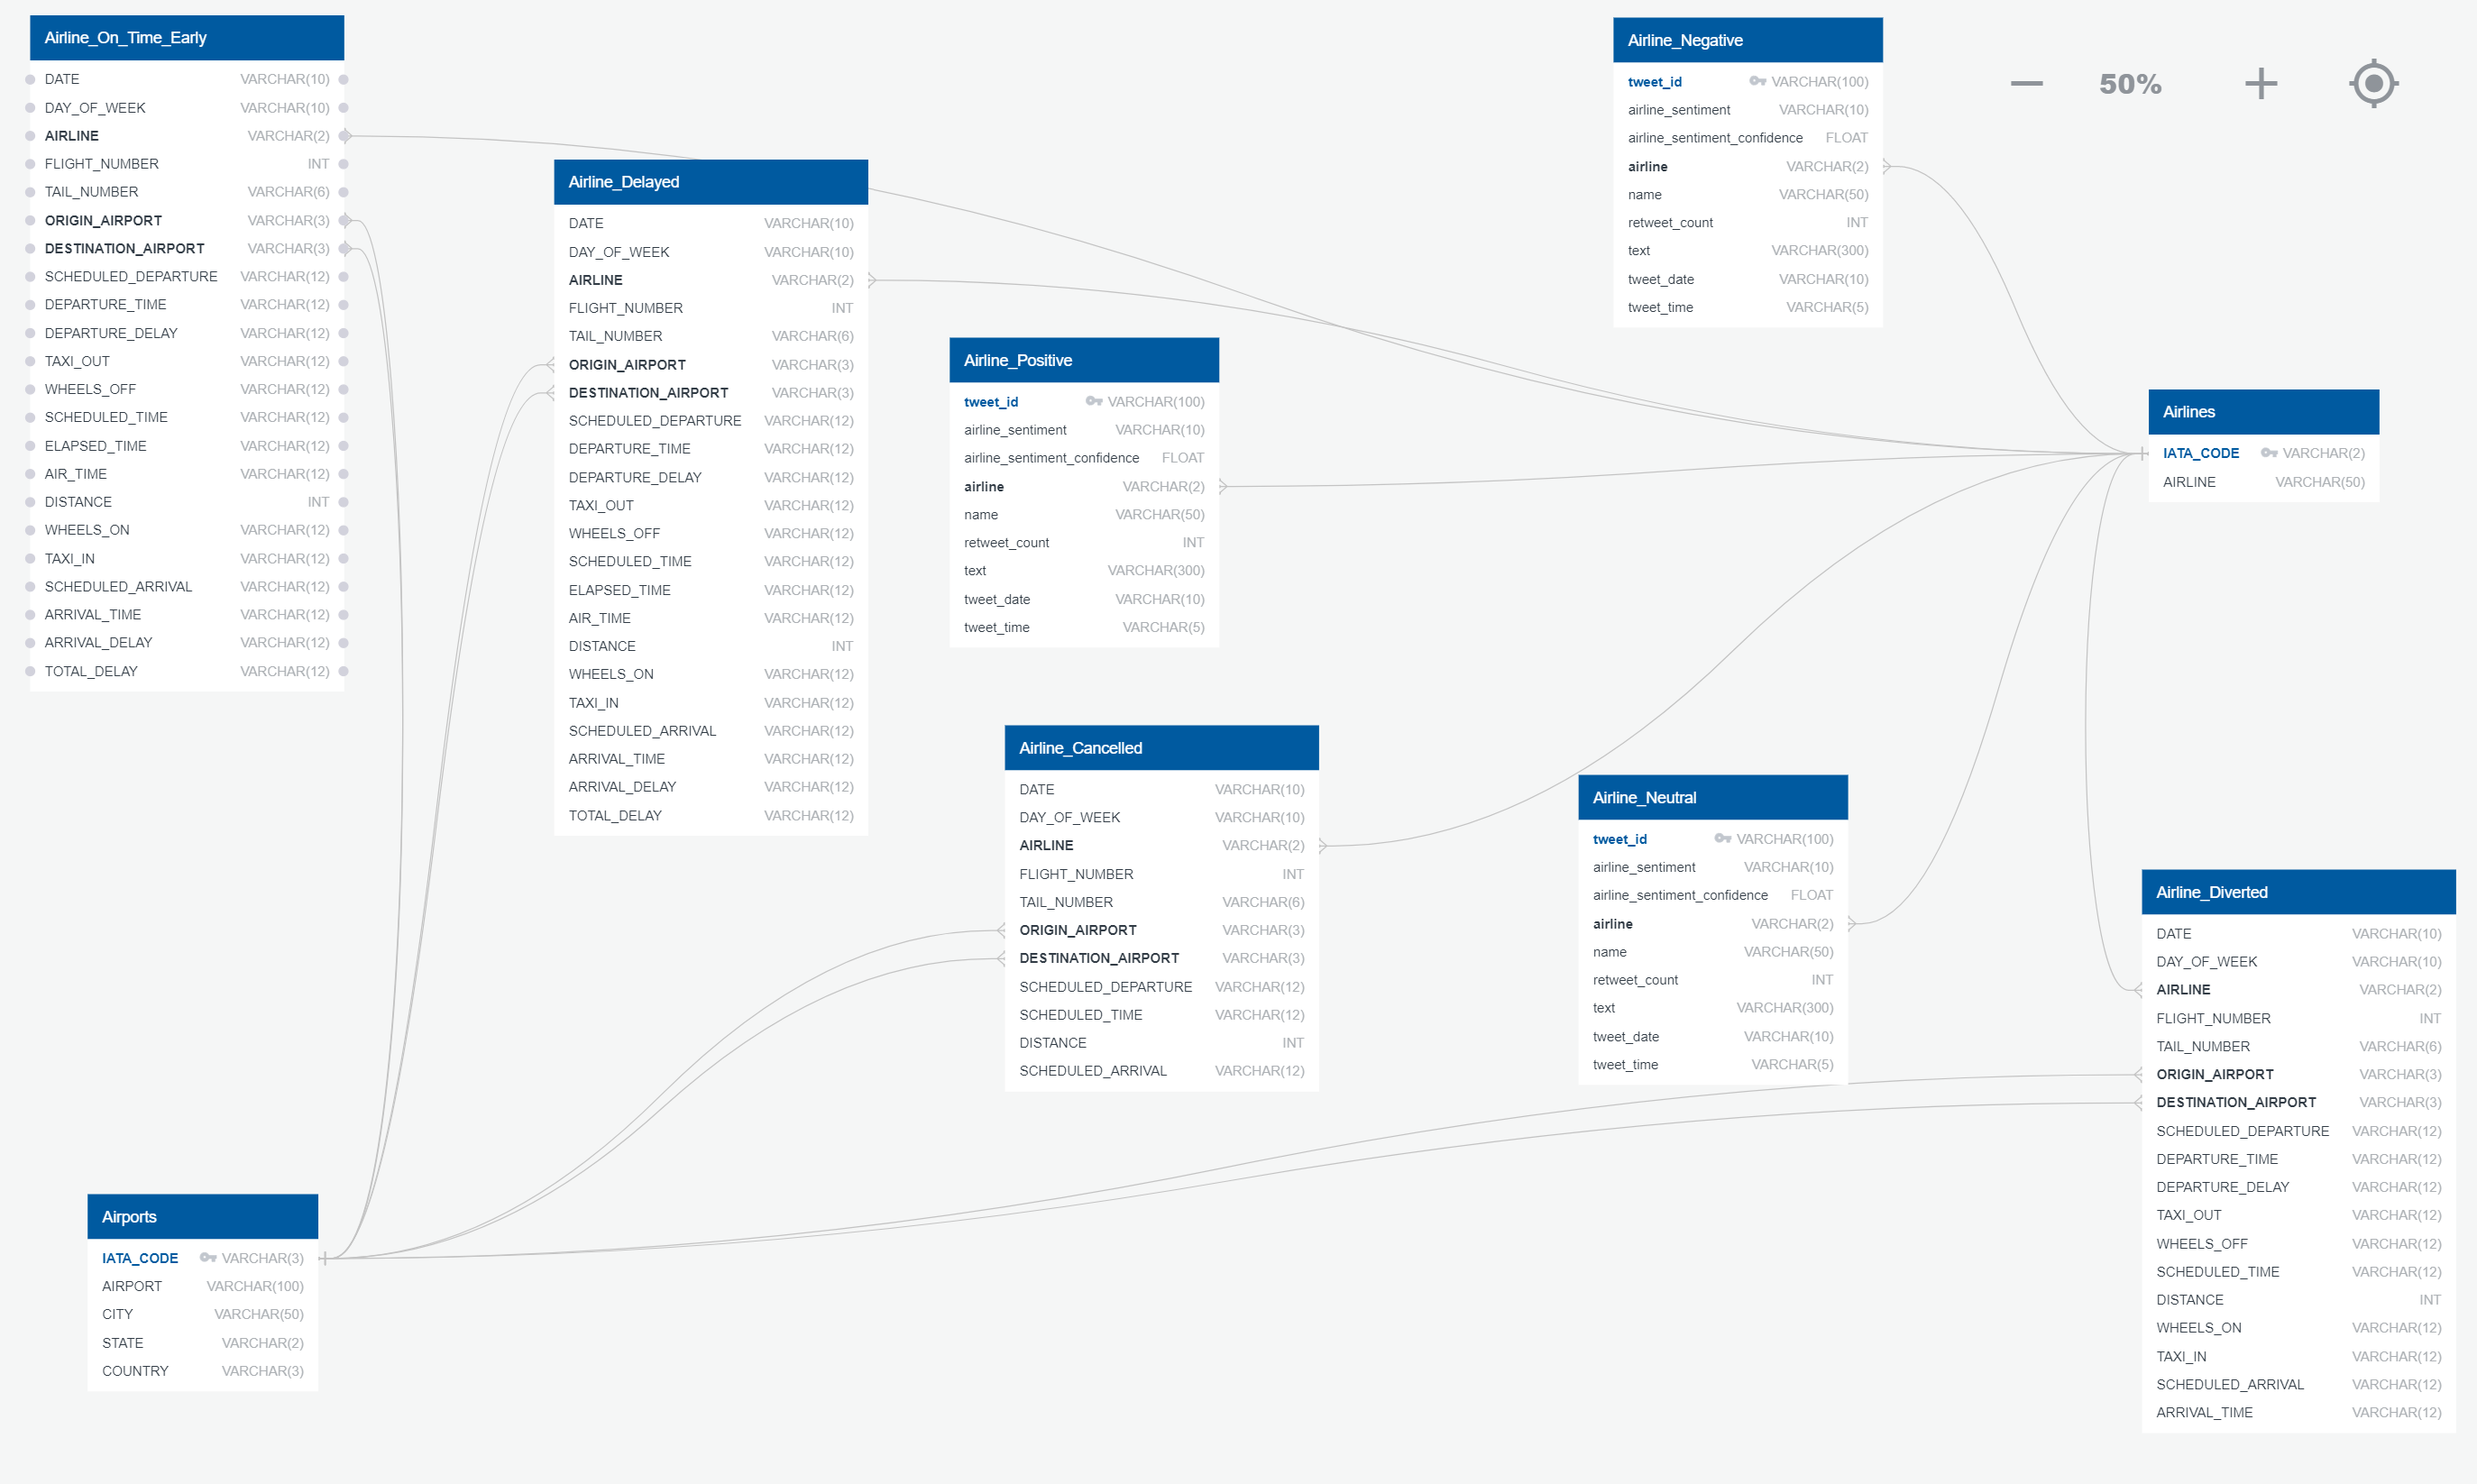

In [70]:
#Import Database Key
from db_keys import db_key

#Connect to PostgreSQL Database
pg_engine = create_engine('postgresql://' + db_key + '@localhost:5432/flights_tweets_db')

In [71]:
#Create Airlines Table
pg_engine.execute('CREATE TABLE "Airlines" ("IATA_CODE" VARCHAR(2) PRIMARY KEY, "AIRLINE" VARCHAR(50) NOT NULL);')

In [72]:
#Add Airlines Data Frame to Airlines Table
airline_df.to_sql("Airlines", pg_engine, if_exists = 'append', index = False)

In [73]:
#Create Airports Table
pg_engine.execute('CREATE TABLE "Airports" ("IATA_CODE" VARCHAR(3) PRIMARY KEY, "AIRPORT" VARCHAR(100) NOT NULL, "CITY" VARCHAR(50) NOT NULL, "STATE" VARCHAR(2) NOT NULL, "COUNTRY" VARCHAR(3) NOT NULL);')

In [74]:
#Add Airports Data Frame to Airports Table
airports_df.to_sql("Airports", pg_engine, if_exists = 'append', index = False)

In [75]:
#Create UA Early Table
pg_engine.execute('CREATE TABLE "UA_Early" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "ELAPSED_TIME" VARCHAR(12), "AIR_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "ARRIVAL_DELAY" VARCHAR(12), "TOTAL_DELAY" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [76]:
#Add UA Early Data Frame to UA Early Table
UA_Early.to_sql("UA_Early", pg_engine, if_exists = 'append', index = False)

In [77]:
#Create AA Early Table
pg_engine.execute('CREATE TABLE "AA_Early" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "ELAPSED_TIME" VARCHAR(12), "AIR_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "ARRIVAL_DELAY" VARCHAR(12), "TOTAL_DELAY" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [78]:
#Add AA Early Data Frame to AA Early Table
AA_Early.to_sql("AA_Early", pg_engine, if_exists = 'append', index = False)

In [79]:
#Create DL Early Table
pg_engine.execute('CREATE TABLE "DL_Early" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "ELAPSED_TIME" VARCHAR(12), "AIR_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "ARRIVAL_DELAY" VARCHAR(12), "TOTAL_DELAY" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [80]:
#Add DL Early Data Frame to DL Early Table
DL_Early.to_sql("DL_Early", pg_engine, if_exists = 'append', index = False)

In [81]:
#Create US Early Table
pg_engine.execute('CREATE TABLE "US_Early" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "ELAPSED_TIME" VARCHAR(12), "AIR_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "ARRIVAL_DELAY" VARCHAR(12), "TOTAL_DELAY" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [82]:
#Add US Early Data Frame to US Early Table
US_Early.to_sql("US_Early", pg_engine, if_exists = 'append', index = False)

In [83]:
#Create WN Early Table
pg_engine.execute('CREATE TABLE "WN_Early" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "ELAPSED_TIME" VARCHAR(12), "AIR_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "ARRIVAL_DELAY" VARCHAR(12), "TOTAL_DELAY" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [84]:
#Add WN Early Data Frame to WN Early Table
WN_Early.to_sql("WN_Early", pg_engine, if_exists = 'append', index = False)

In [85]:
#Create VX Early Table
pg_engine.execute('CREATE TABLE "VX_Early" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "ELAPSED_TIME" VARCHAR(12), "AIR_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "ARRIVAL_DELAY" VARCHAR(12), "TOTAL_DELAY" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [86]:
#Add VX Early Data Frame to VX Early Table
VX_Early.to_sql("VX_Early", pg_engine, if_exists = 'append', index = False)

In [87]:
#Create UA Late Table
pg_engine.execute('CREATE TABLE "UA_Late" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "ELAPSED_TIME" VARCHAR(12), "AIR_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "ARRIVAL_DELAY" VARCHAR(12), "TOTAL_DELAY" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [88]:
#Add UA Late Data Frame to UA Late Table
UA_Late.to_sql("UA_Late", pg_engine, if_exists = 'append', index = False)

In [89]:
#Create AA Late Table
pg_engine.execute('CREATE TABLE "AA_Late" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "ELAPSED_TIME" VARCHAR(12), "AIR_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "ARRIVAL_DELAY" VARCHAR(12), "TOTAL_DELAY" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [90]:
#Add AA Late Data Frame to AA Late Table
AA_Late.to_sql("AA_Late", pg_engine, if_exists = 'append', index = False)

In [91]:
#Create DL Late Table
pg_engine.execute('CREATE TABLE "DL_Late" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "ELAPSED_TIME" VARCHAR(12), "AIR_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "ARRIVAL_DELAY" VARCHAR(12), "TOTAL_DELAY" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [92]:
#Add DL Late Data Frame to DL Late Table
DL_Late.to_sql("DL_Late", pg_engine, if_exists = 'append', index = False)

In [93]:
#Create US Late Table
pg_engine.execute('CREATE TABLE "US_Late" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "ELAPSED_TIME" VARCHAR(12), "AIR_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "ARRIVAL_DELAY" VARCHAR(12), "TOTAL_DELAY" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [94]:
#Add US Late Data Frame to US Late Table
US_Late.to_sql("US_Late", pg_engine, if_exists = 'append', index = False)

In [95]:
#Create WN Late Table
pg_engine.execute('CREATE TABLE "WN_Late" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "ELAPSED_TIME" VARCHAR(12), "AIR_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "ARRIVAL_DELAY" VARCHAR(12), "TOTAL_DELAY" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [96]:
#Add WN Late Data Frame to WN Late Table
WN_Late.to_sql("WN_Late", pg_engine, if_exists = 'append', index = False)

In [97]:
#Create VX Late Table
pg_engine.execute('CREATE TABLE "VX_Late" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "ELAPSED_TIME" VARCHAR(12), "AIR_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "ARRIVAL_DELAY" VARCHAR(12), "TOTAL_DELAY" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [98]:
#Add VX Late Data Frame to VX Late Table
VX_Late.to_sql("VX_Late", pg_engine, if_exists = 'append', index = False)

In [99]:
#Create UA Diverted Table
pg_engine.execute('CREATE TABLE "UA_Diverted" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [100]:
#Add UA Diverted Data Frame to UA Diverted Table
UA_Diverted.to_sql("UA_Diverted", pg_engine, if_exists = 'append', index = False)

In [101]:
#Create AA Diverted Table
pg_engine.execute('CREATE TABLE "AA_Diverted" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [102]:
#Add AA Diverted Data Frame to AA Diverted Table
AA_Diverted.to_sql("AA_Diverted", pg_engine, if_exists = 'append', index = False)

In [103]:
#Create DL Diverted Table
pg_engine.execute('CREATE TABLE "DL_Diverted" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [104]:
#Add DL Diverted Data Frame to DL Diverted Table
DL_Diverted.to_sql("DL_Diverted", pg_engine, if_exists = 'append', index = False)

In [105]:
#Create US Diverted Table
pg_engine.execute('CREATE TABLE "US_Diverted" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [106]:
#Add US Diverted Data Frame to US Diverted Table
US_Diverted.to_sql("US_Diverted", pg_engine, if_exists = 'append', index = False)

In [107]:
#Create WN Diverted Table
pg_engine.execute('CREATE TABLE "WN_Diverted" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [108]:
#Add WN Diverted Data Frame to WN Diverted Table
WN_Diverted.to_sql("WN_Diverted", pg_engine, if_exists = 'append', index = False)

In [109]:
#Create VX Diverted Table
pg_engine.execute('CREATE TABLE "VX_Diverted" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "DEPARTURE_TIME" VARCHAR(12), "DEPARTURE_DELAY" VARCHAR(12), "TAXI_OUT" VARCHAR(12), "WHEELS_OFF" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "DISTANCE" INT, "WHEELS_ON" VARCHAR(12), "TAXI_IN" VARCHAR(12), "SCHEDULED_ARRIVAL" VARCHAR(12), "ARRIVAL_TIME" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [110]:
#Add VX Diverted Data Frame to VX Diverted Table
VX_Diverted.to_sql("VX_Diverted", pg_engine, if_exists = 'append', index = False)

In [111]:
#Create UA Cancelled Table
pg_engine.execute('CREATE TABLE "UA_Cancelled" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "DISTANCE" INT, "SCHEDULED_ARRIVAL" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [112]:
#Add UA Cancelled Data Frame to UA Cancelled Table
UA_Cancelled.to_sql("UA_Cancelled", pg_engine, if_exists = 'append', index = False)

In [113]:
#Create AA Cancelled Table
pg_engine.execute('CREATE TABLE "AA_Cancelled" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "DISTANCE" INT, "SCHEDULED_ARRIVAL" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [114]:
#Add AA Cancelled Data Frame to AA Cancelled Table
AA_Cancelled.to_sql("AA_Cancelled", pg_engine, if_exists = 'append', index = False)

In [115]:
#Create DL Cancelled Table
pg_engine.execute('CREATE TABLE "DL_Cancelled" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "DISTANCE" INT, "SCHEDULED_ARRIVAL" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [116]:
#Add DL Cancelled Data Frame to DL Cancelled Table
DL_Cancelled.to_sql("DL_Cancelled", pg_engine, if_exists = 'append', index = False)

In [117]:
#Create US Cancelled Table
pg_engine.execute('CREATE TABLE "US_Cancelled" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "DISTANCE" INT, "SCHEDULED_ARRIVAL" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [118]:
#Add US Cancelled Data Frame to US Cancelled Table
US_Cancelled.to_sql("US_Cancelled", pg_engine, if_exists = 'append', index = False)

In [119]:
#Create WN Cancelled Table
pg_engine.execute('CREATE TABLE "WN_Cancelled" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "DISTANCE" INT, "SCHEDULED_ARRIVAL" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [120]:
#Add WN Cancelled Data Frame to WN Cancelled Table
WN_Cancelled.to_sql("WN_Cancelled", pg_engine, if_exists = 'append', index = False)

In [121]:
#Create VX Cancelled Table
pg_engine.execute('CREATE TABLE "VX_Cancelled" ("DAY_OF_WEEK" VARCHAR(10), "AIRLINE" VARCHAR(2), "FLIGHT_NUMBER" INT, "TAIL_NUMBER" VARCHAR(6), "ORIGIN_AIRPORT" VARCHAR(3), "DESTINATION_AIRPORT" VARCHAR(3), "SCHEDULED_DEPARTURE" VARCHAR(12), "SCHEDULED_TIME" VARCHAR(12), "DISTANCE" INT, "SCHEDULED_ARRIVAL" VARCHAR(12), "DATE" VARCHAR(10), FOREIGN KEY ("ORIGIN_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("DESTINATION_AIRPORT") REFERENCES "Airports" ("IATA_CODE"), FOREIGN KEY ("AIRLINE") REFERENCES "Airlines" ("IATA_CODE"));')

In [122]:
#Add VX Cancelled Data Frame to VX Cancelled Table
VX_Cancelled.to_sql("VX_Cancelled", pg_engine, if_exists = 'append', index = False)

In [123]:
#Create UA Positive Table
pg_engine.execute('CREATE TABLE "UA_Positive" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [124]:
#Add UA Positive Data Frame to UA Positive Table
UA_positive.to_sql("UA_Positive", pg_engine, if_exists = 'append', index = False)

In [125]:
#Create AA Positive Table
pg_engine.execute('CREATE TABLE "AA_Positive" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [126]:
#Add AA Positive Data Frame to AA Positive Table
AA_positive.to_sql("AA_Positive", pg_engine, if_exists = 'append', index = False)

In [127]:
#Create DL Positive Table
pg_engine.execute('CREATE TABLE "DL_Positive" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [128]:
#Add DL Positive Data Frame to DL Positive Table
DL_positive.to_sql("DL_Positive", pg_engine, if_exists = 'append', index = False)

In [129]:
#Create US Positive Table
pg_engine.execute('CREATE TABLE "US_Positive" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [130]:
#Add US Positive Data Frame to US Positive Table
US_positive.to_sql("US_Positive", pg_engine, if_exists = 'append', index = False)

In [131]:
#Create WN Positive Table
pg_engine.execute('CREATE TABLE "WN_Positive" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [132]:
#Add WN Positive Data Frame to WN Positive Table
WN_positive.to_sql("WN_Positive", pg_engine, if_exists = 'append', index = False)

In [133]:
#Create VX Positive Table
pg_engine.execute('CREATE TABLE "VX_Positive" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [134]:
#Add VX Positive Data Frame to VX Positive Table
VX_positive.to_sql("VX_Positive", pg_engine, if_exists = 'append', index = False)

In [135]:
#Create UA Neutral Table
pg_engine.execute('CREATE TABLE "UA_Neutral" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [136]:
#Add UA Neutral Data Frame to UA Neutral Table
UA_neutral.to_sql("UA_Neutral", pg_engine, if_exists = 'append', index = False)

In [137]:
#Create AA Neutral Table
pg_engine.execute('CREATE TABLE "AA_Neutral" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [138]:
#Add AA Neutral Data Frame to AA Neutral Table
AA_neutral.to_sql("AA_Neutral", pg_engine, if_exists = 'append', index = False)

In [139]:
#Create DL Neutral Table
pg_engine.execute('CREATE TABLE "DL_Neutral" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [140]:
#Add DL Neutral Data Frame to DL Neutral Table
DL_neutral.to_sql("DL_Neutral", pg_engine, if_exists = 'append', index = False)

In [141]:
#Create US Neutral Table
pg_engine.execute('CREATE TABLE "US_Neutral" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [142]:
#Add US Neutral Data Frame to US Neutral Table
US_neutral.to_sql("US_Neutral", pg_engine, if_exists = 'append', index = False)

In [143]:
#Create WN Neutral Table
pg_engine.execute('CREATE TABLE "WN_Neutral" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [144]:
#Add WN Neutral Data Frame to WN Neutral Table
WN_neutral.to_sql("WN_Neutral", pg_engine, if_exists = 'append', index = False)

In [145]:
#Create VX Neutral Table
pg_engine.execute('CREATE TABLE "VX_Neutral" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [146]:
#Add VX Neutral Data Frame to VX Neutral Table
VX_neutral.to_sql("VX_Neutral", pg_engine, if_exists = 'append', index = False)

In [147]:
#Create UA Negative Table
pg_engine.execute('CREATE TABLE "UA_Negative" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [148]:
#Add UA Negative Data Frame to UA Negative Table
UA_negative.to_sql("UA_Negative", pg_engine, if_exists = 'append', index = False)

In [149]:
#Create AA Negative Table
pg_engine.execute('CREATE TABLE "AA_Negative" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [150]:
#Add AA Neutral Data Frame to AA Neutral Table
AA_negative.to_sql("AA_Negative", pg_engine, if_exists = 'append', index = False)

In [151]:
#Create DL Negative Table
pg_engine.execute('CREATE TABLE "DL_Negative" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [152]:
#Add DL Neutral Data Frame to DL Neutral Table
DL_negative.to_sql("DL_Negative", pg_engine, if_exists = 'append', index = False)

In [153]:
#Create US Negative Table
pg_engine.execute('CREATE TABLE "US_Negative" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [154]:
#Add US Neutral Data Frame to US Neutral Table
US_negative.to_sql("US_Negative", pg_engine, if_exists = 'append', index = False)

In [155]:
#Create WN Negative Table
pg_engine.execute('CREATE TABLE "WN_Negative" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [156]:
#Add WN Neutral Data Frame to WN Neutral Table
WN_negative.to_sql("WN_Negative", pg_engine, if_exists = 'append', index = False)

In [157]:
#Create VX Negative Table
pg_engine.execute('CREATE TABLE "VX_Negative" ("tweet_id" VARCHAR(100) PRIMARY KEY, "airline_sentiment" VARCHAR(10), "airline_sentiment_confidence" FLOAT, "airline" VARCHAR(2), "name" VARCHAR(50), "retweet_count" INT, "text" VARCHAR(300), "tweet_date" VARCHAR(10), "tweet_time" VARCHAR(5), FOREIGN KEY ("airline") REFERENCES "Airlines" ("IATA_CODE"));')

In [158]:
#Add VX Neutral Data Frame to VX Neutral Table
VX_negative.to_sql("VX_Negative", pg_engine, if_exists = 'append', index = False)

# Project Analysis (Matt)

The purpose of this project was to perform an Extract-Transform-Load (ETL) process on airline flight performance data and customer tweet data from February 2015. The approach was to use the SQLAlchemy and Pandas modules in Python to extract and transform the data. SQLAlchemy was then used to load the transformed data into a PostgreSQL database.

## Data Extraction

The extraction phase of the ETL process included importing and inspecting the data. First, four files needed to be imported into Python, three CSV files of flight performance data and one SQLite database file of customer tweet data. A direct import to a Pandas data frame was performed for each of the three CSV files, which contained flight, airline, and airport information respectively. In order to access the SQLite database file, a connection was established through the SQLAlchemy engine and the table names were exported. The tweet information table was then extracted from the database directly to a Pandas data frame.

With the import process complete, the next step was to thoroughly inspect each of the four data frames. The inspection identified several issues and inconsistencies. First, the date range of the tweet information data frame was narrower than the date range of the flight information data frame. Second, several columns in the flight and tweet information data frames were missing large amounts of data. Third, the format of date and time values in the flight and tweet information data frames was not consistent. Fourth, the tweet information data frame contained fewer airlines than the flight and airline information data frames. Finally, the latitude and longitude information for certain airports was incomplete in the airport information data frame.

## Data Transformation

The next phase of the ETL process was to clean the data and transform it into a relational database-ready format. This process for each of the four original data frames primarily used the Pandas module in Python. The flight information data frame was filtered into individual data frames for early, late, diverted, and cancelled flights. Each of these new data frames was then cleaned by dropping columns missing large amounts of data or with irrelevant data, followed by removing rows with missing values. Next, the transformation process began by creating a column of calculated total delay time (early and late flight data frames only), and replacing the year, month, and day columns with a single date column. The numeric values representing the day of the week for each date were also replaced with the actual names of each day. The Datetime module was then used to convert all integer time values to actual time strings. Finally, each of the new data frames was split into groups based on airline and each group was saved as a unique data frame. These processed data frames represented individual database tables of early, late, cancelled, and diverted flights for each airline. The airline and airport information data frames required fewer cleaning and transformation steps. The former only needed to be filtered by airline, while the latter only needed two columns dropped due to missing data. 

The cleaning and transformation of the tweet information data frame required several steps. First, columns missing large amounts of data were dropped, followed by removing rows with missing values. The data frame was then sorted by date and the column of airline names was replaced with airline codes. Next, the tweet date and time column was replaced by separate columns for tweet date and tweet time respectively. Finally, the data frame was split into groups based on airline and tweet type, and each group was saved as a unique data frame. These processed data frames represented individual database tables of positive, neutral, and negative tweets for each airline.

## Data Loading

The final phase of the ETL process was to establish the relationships between the processed data frames and load them into a relational database. It was determined that the airport information data frame and airline information data frame would have primary keys of airport and airline code respectively. Next, the processed data frames for early, late, diverted, and cancelled flights for each airline would have foreign keys of airline and airport code. Finally, the processed data frames for positive, neutral, and negative tweets for each airline would have a primary key of tweet identification number and a foreign key of airline code. These relationships were then used to create an Entity Relationship Diagram (ERD) to visualize the links between the planned database tables.

In order to convert the data frames into tables, a database was created in PostgreSQL and a connection to it was established with Python. Each table was created by submitting a command to the database through the SQLAlchemy module, which included the appropriate key definitions. Finally, the aforementioned tables were populated with information from the appropriate data frames  through a similar process.